 # Final Assignment

## 1 Dataset Selection and Preparation

### 1.1 Dataset Selection and Preparation: Dataset Description

I chose the Support dataset provided by Vanderbilt University Department of Biostatistics and hosted on the UC Irving Machine Learning Repository (https://archive.ics.uci.edu/dataset/880/support2, https://hbiostat.org/data/repo/supportdesc). The Robert Wood Johnson Foundation funded the creation of this dataset (https://www.rwjf.org/).

The Support dataset is comprised of 9105 individual critically ill patients accross 5 medical centers in the United States over 1989-1991 and 1992-1994. The original goal of the dataset was to determine the patients 2 and 6 month survival rates based on available information including physiological, demographical and disease severity or symptom information. The Support dataset has 9105 instances and 42 features with various continous and categorical variables. This is a very rich dataset that hopefully will be of interest to a wide range of audiences.

I aim to explore the use of neural networks and logistic regression models to predict whether or not a patient will die "hospdead" which is a binary 0, 1 variable. Given it is a classification task I have disregarded the use of a linear regression and consider instead logistic regression, bayesian inference (with logistic regression) and neural network models. 

It is recognised that some of the information in relation to particularly gender, race, income and educational level should be approached in a sensitive way. Data provided has been anonymised and individual patients are not identifiable in any way. 



In [2661]:
#dataset
from ucimlrepo import fetch_ucirepo 

# charting and dframes
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns

# Modelling
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.naive_bayes import CategoricalNB
from sklearn.preprocessing import MinMaxScaler

# Standard imports 
import seaborn as sn
import statsmodels.api as sm

# Required for modeling and evaluation
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import log_loss
from scipy.optimize import minimize


#neural net
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, classification_report

In [3077]:
torch.cuda.is_available()

False

In [2662]:
 # fetch dataset 
support2 = fetch_ucirepo(id=880) 
  
# data (as pandas dataframes) 
X = support2.data.features 
y = support2.data.targets 

  
# variable information 
#I use this reference information later when I describe and relate the features of X
#print(support2.variables) 

### 1.2 Dataset Selection and Preparation: Overview of processes

The process used in this project was as follows:
1. Data preprocessing and cleaning stage
2. Splitting into train and test sets
3. Preliminary Model 1 Logistic Regression
4. Data Exploration and curation of training features. Further data processing including transformations was undertaken during this stage.
5. Training of Models 2-5. Logistic Regressions on various curated data
6. Neural Network Model 6-7
7. Bayesian inferance model Model 8.
8. Model Evaluation and discussion of models


### 1.1 Dataset Selection and Preparation. Summary of dependant and independant variables

In order to understand better the patient dataset both to validate it and also to allow for more meainginful evaluation and interpretation of the later modelling steps I applied the described function to the dependant variable and independant variables.

There is nothing particularly noteworthy in terms of the X variables the explanatory or independant variables except that we can see that whereas we had 42 columns originally we now have only 35 since some of the categorical variables have not been encoded accordingly. This will mean that I will need to encode the missing items (the categorical variables) separately in the processing stage.

However for Y below it is worth noting that 25.9% of patients did die in hospital. This is noteworthy as it means that there is a class imbalance with more patients surviving than not; this means that we will want to make use of micro averaging to correct for the class imbalance later on when we move into the Model Evaluation phase.

In [3430]:
X.describe()

,age,num.co,edu,scoma,charges,totcst,totmcst,avtisst,sps,aps,...,bili,crea,sod,ph,glucose,bun,urine,adlp,adls,adlsc
count,9105.000000,9105.000000,7471.000000,9104.000000,8.933000e+03,8217.000000,5630.000000,9023.000000,9104.000000,9104.000000,...,6504.000000,9038.000000,9104.000000,6821.000000,4605.000000,4753.000000,4243.000000,3464.000000,6238.000000,9105.000000
mean,62.650823,1.868644,11.747691,12.058546,5.999579e+04,30825.867768,28828.877838,22.610928,25.525872,37.597979,...,2.554463,1.770961,137.568541,7.415364,159.873398,32.349463,2191.546047,1.157910,1.637384,1.888272
std,15.593710,1.344409,3.447743,24.636694,1.026488e+05,45780.820986,43604.261932,13.233248,9.899377,19.903852,...,5.318448,1.686041,6.029326,0.080563,88.391541,26.792288,1455.245777,1.739672,2.231358,2.003763
min,18.041990,0.000000,0.000000,0.000000,1.169000e+03,0.000000,-102.719970,1.000000,0.199982,0.000000,...,0.099991,0.099991,110.000000,6.829102,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,52.797000,1.000000,10.000000,0.000000,9.740000e+03,5929.566400,5177.404300,12.000000,19.000000,23.000000,...,0.500000,0.899902,134.000000,7.379883,103.000000,14.000000,1165.500000,0.000000,0.000000,0.000000
50%,64.856990,2.000000,12.000000,0.000000,2.502400e+04,14452.734400,13223.500000,19.500000,23.898438,34.000000,...,0.899902,1.199951,137.000000,7.419922,135.000000,23.000000,1968.000000,0.000000,1.000000,1.000000
75%,73.998960,3.000000,14.000000,9.000000,6.459800e+04,36087.937500,34223.601600,31.666656,30.199219,49.000000,...,1.899902,1.899902,141.000000,7.469727,188.000000,42.000000,3000.000000,2.000000,3.000000,3.000000
max,101.847960,9.000000,31.000000,100.000000,1.435423e+06,633212.000000,710682.000000,83.000000,99.187500,143.000000,...,63.000000,21.500000,181.000000,7.769531,1092.000000,300.000000,9000.000000,7.000000,7.000000,7.073242


In [2668]:
#I extracted the "hospdead" with 0 for survived and 1 for died in hospital
Y=y[['hospdead']]
Y

Y.describe()

,hospdead
count,9105.000000
mean,0.259198
std,0.438219
min,0.000000
25%,0.000000
50%,0.000000
75%,1.000000
max,1.000000


## 2 Data Preprocessing

The objective of data preprocessing is to prepare the dataset for training the various models and secondarily to identify any potential issues that should be taken into account. Broadly speaking the data preprocessing stage comprised these steps:
* Identifying and processing NA values by feature. Where appropriate missing values were imputed according to the mean or most frequent item if categorical data, where large numbers of NAs were present removal of a feature entirely was considered.
* Encoding categorical data according to one-hot or vector encoding where categorical data is nominal, or mapping accordingly in the case where it is ordinal.
* Removing any clearly redundant or duplicated data for instance where a column has a clear dependancy on another column. Please note I do much more detailed analysis of independance of features in the exploratory data analysis phase.
* Scaling columns by standardising values. This is particularly important for the neural network model which is highly sensitive to the input value size but also it would reduce the impact of outliers and any non-linear behaviour on model calibration which will also be important for logistic regressions too.

### 2.1 Data Preprocessing: Evaluating and Processing NA values

I checked both X, the independant or features, and Y the dependant variable ("hospdead") for the presence of NAs.

I find that Y has no NAs, while X has NAs in some columns and some columns have many NAs. For example we see that totmcst has 3475 NAs, given that we only have 9105 observations this is very significant (38% of entries) while charges had 172 NAs amounting to 1.9% of all observations. 

In order to simplify data processing and intepretability I removed any column that had more 10% or more NAs (i.e 911) as at that point I believed it would interfere too much it the final results.


In [2673]:
Y.isnull().sum()

hospdead    0
dtype: int64

In [2674]:
X.isnull().sum()

age            0
sex            0
dzgroup        0
dzclass        0
num.co         0
edu         1634
income      2982
scoma          1
charges      172
totcst       888
totmcst     3475
avtisst       82
race          42
sps            1
aps            1
surv2m         1
surv6m         1
hday           0
diabetes       0
dementia       0
ca             0
prg2m       1649
prg6m       1633
dnr           30
dnrday        30
meanbp         1
wblc         212
hrt            1
resp           1
temp           1
pafi        2325
alb         3372
bili        2601
crea          67
sod            1
ph          2284
glucose     4500
bun         4352
urine       4862
adlp        5641
adls        2867
adlsc          0
dtype: int64

In [2675]:
#removing all columns with more than 10% NANs
X2=X.copy()
X2=X2.drop(X2.columns[X2.isnull().mean()>0.1], axis=1)
X2.isnull().sum()

age           0
sex           0
dzgroup       0
dzclass       0
num.co        0
scoma         1
charges     172
totcst      888
avtisst      82
race         42
sps           1
aps           1
surv2m        1
surv6m        1
hday          0
diabetes      0
dementia      0
ca            0
dnr          30
dnrday       30
meanbp        1
wblc        212
hrt           1
resp          1
temp          1
crea         67
sod           1
adlsc         0
dtype: int64

### 2.2 Data Preprocessing: Imputing NA values

In order to help determine how best to deal with the remaining NAs I use describe on the columns that remain that also have NAs. 
Important to note here that the categorical variables will have to be dealt with separately by determining the most frequent category and imputing accordingly.

In [2678]:
X2.describe()

,age,num.co,scoma,charges,totcst,avtisst,sps,aps,surv2m,surv6m,...,dementia,dnrday,meanbp,wblc,hrt,resp,temp,crea,sod,adlsc
count,9105.000000,9105.000000,9104.000000,8.933000e+03,8217.000000,9023.000000,9104.000000,9104.000000,9104.000000,9104.000000,...,9105.000000,9075.000000,9104.000000,8893.000000,9104.000000,9104.000000,9104.000000,9038.000000,9104.000000,9105.000000
mean,62.650823,1.868644,12.058546,5.999579e+04,30825.867768,22.610928,25.525872,37.597979,0.635870,0.520096,...,0.032510,14.582590,84.546408,12.347677,97.156711,23.330294,37.103341,1.770961,137.568541,1.888272
std,15.593710,1.344409,24.636694,1.026488e+05,45780.820986,13.233248,9.899377,19.903852,0.248175,0.253343,...,0.177359,19.944216,27.687692,9.266329,31.559292,9.573801,1.251796,1.686041,6.029326,2.003763
min,18.041990,0.000000,0.000000,1.169000e+03,0.000000,1.000000,0.199982,0.000000,0.000000,0.000000,...,0.000000,-88.000000,0.000000,0.000000,0.000000,0.000000,31.699220,0.099991,110.000000,0.000000
25%,52.797000,1.000000,0.000000,9.740000e+03,5929.566400,12.000000,19.000000,23.000000,0.507690,0.342957,...,0.000000,4.000000,63.000000,7.000000,72.000000,18.000000,36.195310,0.899902,134.000000,0.000000
50%,64.856990,2.000000,0.000000,2.502400e+04,14452.734400,19.500000,23.898438,34.000000,0.715942,0.574951,...,0.000000,9.000000,77.000000,10.599609,100.000000,24.000000,36.695310,1.199951,137.000000,1.000000
75%,73.998960,3.000000,9.000000,6.459800e+04,36087.937500,31.666656,30.199219,49.000000,0.825928,0.725952,...,0.000000,17.000000,107.000000,15.298828,120.000000,28.000000,38.195310,1.899902,141.000000,3.000000
max,101.847960,9.000000,100.000000,1.435423e+06,633212.000000,83.000000,99.187500,143.000000,0.969971,0.947998,...,1.000000,285.000000,195.000000,200.000000,300.000000,90.000000,41.695310,21.500000,181.000000,7.073242



I am particularly interested in determining whether to impute the missing values using the mean of each column or the median, or zero . In cases where most of the time the value is zero then I use the median otherwise I take the mean,  in the case of .


* In case of "scoma" replace the NaNs with zero rather than the mean, we can see that in majority of cases the value is zero so the mean actually would not be represenative, indeed the median is zero.  
* In the case of race I use a default the race to 1 when no race is provided. I chose to do this rather than use 0 or "other" as I believed that that wouled interfere less with the results given 1 is the most common value. 
* I replace NaNs of dnr to 0 where it is not provided (i.e that no DNR is provided)- we see that most values that are available are 0 and also logically that should be the default i.e no do not recussitate order.
* In all other cases I replace the NANs with the mean of each column.

In [2680]:
#I remove dzclass as it's not independant to and is more general than dzgroup which is more specific
X2 = X2.drop('dzclass', axis=1)


#first replace NaNs in categoical columns using customised processes as appropriate
#I used in each case the most common category
X2 = X2.fillna({'scoma': 0, 'race':'white','dnr':'no dnr', 'ca':'no' })
#replace all other columns with column means
X2=X2.fillna(X2.mean())

#check that no NAs remain
X2.isnull().sum()

/var/folders/2t/dswlrlgs7r55b7gdz46sp2hc0000gn/T/ipykernel_94948/2380875673.py:9: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  X2=X2.fillna(X2.mean())


age         0
sex         0
dzgroup     0
num.co      0
scoma       0
charges     0
totcst      0
avtisst     0
race        0
sps         0
aps         0
surv2m      0
surv6m      0
hday        0
diabetes    0
dementia    0
ca          0
dnr         0
dnrday      0
meanbp      0
wblc        0
hrt         0
resp        0
temp        0
crea        0
sod         0
adlsc       0
dtype: int64

### 2.3 Data Preprocessing: Transforming and Encoding Features

Nomimal categories including sex (male or female), dzgroup (disease group) and race are each given one hot coding (also known as vector coding) accordingly. I deal with ordinal categories separately.

Note that one might argue that dnr (no dnr, dnr before admission and dnr after admission) could also be ordinal given there is a certain sequence or order to an extent. However, we find later doing exploratory analysis that the impact of the categories does not develop in a linear way and there are clear differences in the impact on hospital death between the categories so the judgment was made to treat it as a nominal category.

In [2683]:


# Get one hot encoding of nominal category columns
one_hot = pd.get_dummies(X2[['dzgroup','race', 'ca', 'dnr']])
one_hot

# Drop encoded columns as they are each now encoded so redundant
X2 = X2.drop(['dzgroup','race', 'ca', 'dnr'], axis=1)

# Join the encoded df
X2 = X2.join(one_hot)
X2

,age,sex,num.co,scoma,charges,totcst,avtisst,sps,aps,surv2m,...,race_black,race_hispanic,race_other,race_white,ca_metastatic,ca_no,ca_yes,dnr_dnr after sadm,dnr_dnr before sadm,dnr_no dnr
0,62.84998,male,0,0.0,9715.0,30825.867768,7.000000,33.898438,20.0,0.262939,...,0,0,1,0,1,0,0,0,0,1
1,60.33899,female,2,44.0,34496.0,30825.867768,29.000000,52.695312,74.0,0.001000,...,0,0,0,1,0,1,0,0,0,1
2,52.74698,female,2,0.0,41094.0,30825.867768,13.000000,20.500000,45.0,0.790894,...,0,0,0,1,0,1,0,0,0,1
3,42.38498,female,2,0.0,3075.0,30825.867768,7.000000,20.097656,19.0,0.698975,...,0,0,0,1,1,0,0,0,0,1
4,79.88495,female,1,26.0,50127.0,30825.867768,18.666656,23.500000,30.0,0.634888,...,0,0,0,1,0,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9100,66.07300,male,1,0.0,52870.0,34329.312500,20.333328,16.296875,22.0,0.852905,...,0,0,0,1,0,1,0,0,0,1
9101,55.15399,female,1,41.0,35377.0,23558.500000,18.000000,25.796875,31.0,0.553955,...,0,0,0,1,0,1,0,0,0,1
9102,70.38196,male,1,0.0,46564.0,31409.015600,23.000000,22.699219,39.0,0.741943,...,0,0,0,1,0,1,0,0,0,1
9103,47.01999,male,1,0.0,58439.0,30825.867768,35.500000,40.195312,51.0,0.177979,...,0,0,0,1,0,0,1,1,0,0


The only ordinal category (sex) is encoded accordingly below. 

In [2685]:
#ordinal category
X2['sex']=X2['sex'].map({'male':0, 'female':1})


### 2.4 Scaling Data

Z-score scaling was chosen over min max scaling as z-score scaling handles outliers better and that was a key concern given the nature of the dataset. Scaling was applied to all columns that were not already defaulted to 0 and 1 (the categoorical columns were excluded from this for example).

In [2688]:



# copy the data 
X3 = X2.copy() 
  
# apply normalization technique to Column 1 
column = 'age'
#X3[column] = (X3[column] - X3[column].mean()) / X3[column].std()     
  
    
cols_to_norm = ['age','num.co','scoma', 'charges','totcst','avtisst','sps','aps','surv2m', 'surv6m', 'hday', 'diabetes', 'dementia', 'dnrday',
       'meanbp', 'wblc', 'hrt', 'resp', 'temp', 'crea', 'sod', 'adlsc']

#z scaling first
X3[cols_to_norm] = X3[cols_to_norm].apply(lambda x: (x - x.mean()) / (x.std() ))


#min max scaling now
X3[cols_to_norm] = X3[cols_to_norm].apply(lambda x: (x - x.min()) / (x.max() -x.min()))

    
    
# view normalized data   
display(X3) 

,age,sex,num.co,scoma,charges,totcst,avtisst,sps,aps,surv2m,...,race_black,race_hispanic,race_other,race_white,ca_metastatic,ca_no,ca_yes,dnr_dnr after sadm,dnr_dnr before sadm,dnr_no dnr
0,0.534663,0,0.000000,0.00,0.005958,0.048682,0.073171,0.340431,0.139860,0.271080,...,0,0,1,0,1,0,0,0,0,1
1,0.504702,1,0.222222,0.44,0.023236,0.048682,0.341463,0.530323,0.517483,0.001031,...,0,0,0,1,0,1,0,0,0,1
2,0.414111,1,0.222222,0.00,0.027837,0.048682,0.146341,0.205077,0.314685,0.815379,...,0,0,0,1,0,1,0,0,0,1
3,0.290468,1,0.222222,0.00,0.001329,0.048682,0.073171,0.201012,0.132867,0.720614,...,0,0,0,1,1,0,0,0,0,1
4,0.737930,1,0.111111,0.26,0.034135,0.048682,0.215447,0.235383,0.209790,0.654543,...,0,0,0,1,0,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9100,0.573122,0,0.111111,0.00,0.036047,0.054215,0.235772,0.162615,0.153846,0.879310,...,0,0,0,1,0,1,0,0,0,1
9101,0.442832,1,0.111111,0.41,0.023851,0.037205,0.207317,0.258587,0.216783,0.571105,...,0,0,0,1,0,1,0,0,0,1
9102,0.624537,0,0.111111,0.00,0.031651,0.049603,0.268293,0.227294,0.272727,0.764913,...,0,0,0,1,0,1,0,0,0,1
9103,0.345775,0,0.111111,0.00,0.039930,0.048682,0.420732,0.404044,0.356643,0.183489,...,0,0,0,1,0,0,1,1,0,0


In [2689]:
X2.columns

Index(['age', 'sex', 'num.co', 'scoma', 'charges', 'totcst', 'avtisst', 'sps',
       'aps', 'surv2m', 'surv6m', 'hday', 'diabetes', 'dementia', 'dnrday',
       'meanbp', 'wblc', 'hrt', 'resp', 'temp', 'crea', 'sod', 'adlsc',
       'dzgroup_ARF/MOSF w/Sepsis', 'dzgroup_CHF', 'dzgroup_COPD',
       'dzgroup_Cirrhosis', 'dzgroup_Colon Cancer', 'dzgroup_Coma',
       'dzgroup_Lung Cancer', 'dzgroup_MOSF w/Malig', 'race_asian',
       'race_black', 'race_hispanic', 'race_other', 'race_white',
       'ca_metastatic', 'ca_no', 'ca_yes', 'dnr_dnr after sadm',
       'dnr_dnr before sadm', 'dnr_no dnr'],
      dtype='object')

### 2.5 Data Preprocessing: Splitting data into test and training sets

In [2691]:
# Splitting data into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(X2,Y, test_size=0.2, random_state=3)



### 2.6 Data Preprocessing: Checking for class imbalance
We observe a clear class imbalance with 74% of the dependant variable labelled 0 (i.e survived) and remainder 26% only represent hospital deaths. This has implications for model evaluation- should be using micro precision and micro recall for instance in order to account for such an imbalance.


In [2693]:
#check for distribution of labels

Y_train.value_counts(normalize=True)


hospdead
0           0.741214
1           0.258786
dtype: float64

## 3 Preliminary Model 1 Implementation

### 3.1 Preliminary Model 1 Implementation: Logistic Regression Model Fit

Having curated, processed the original dataset and split into test and training set I fit a logistic regression model below. I add additional functionality to obtain p values for each of the coefficients as with ols in order to help with furthef feature selection and interpretability.

The general approach that was taken in fitting the various logistic regression models was to initially fit a preliminary model to identify statistically signficant features (determined to be those with p-values below 0.05), and then to perform exploratory data analysis to determine dependancies of the statistically significant features making adjustments to training data iteratively and fitting new models accordingly. 

In [2697]:
# Create and fit the linear regression model


#note increased the number of iterations to achieve convergence
model_log = LogisticRegression(max_iter=200)
logistic_fit=model_log.fit(X_train, Y_train.values.ravel())

# Predict on the testing set
Y_pred_log = np.round(model_log.predict(X_test)) # rounded



In [2698]:
#Note that since the logistic model in sci learn does not give ability 
#to extra p values for coefficients I created a M logistic model accordingly

import statsmodels.api as smodel
def SWEEPOperator (pDim, inputM, origDiag, sweepCol = None, tol = 1e-7):
    ''' Implement the SWEEP operator

    Parameter
    ---------
    pDim: dimension of matrix inputM, integer greater than one
    inputM: a square and symmetric matrix, numpy array
    origDiag: the original diagonal elements before any SWEEPing
    sweepCol: a list of columns numbers to SWEEP
    tol: singularity tolerance, positive real

    Return
    ------
    A: negative of a generalized inverse of input matrix
    aliasParam: a list of aliased rows/columns in input matrix
    nonAliasParam: a list of non-aliased rows/columns in input matrix
    '''

    if (sweepCol is None):
        sweepCol = range(pDim)

    aliasParam = []
    nonAliasParam = []

    A = np.copy(inputM)
    ANext = np.zeros((pDim,pDim))

    for k in sweepCol:
        Akk = A[k,k]
        pivot = tol * abs(origDiag[k])
        if (not np.isinf(Akk) and abs(Akk) >= pivot):
            nonAliasParam.append(k)
            ANext = A - np.outer(A[:, k], A[k, :]) / Akk
            ANext[:, k] = A[:, k] / abs(Akk)
            ANext[k, :] = ANext[:, k]
            ANext[k, k] = -1.0 / Akk
        else:
            aliasParam.append(k)
            ANext[:,k] = np.zeros(pDim)
            ANext[k, :] = np.zeros(pDim)
        A = ANext
    return (A, aliasParam, nonAliasParam)

def MNLogisticModel (X, y, maxIter = 20, tolSweep = 1e-7):
    ''' Train a Multinomial Logistic Model

    Parameter
    ---------
    X: A Pandas DataFrame, rows are observations, columns are regressors
    y: A Pandas Series, rows are observations of the response variable
    maxIter: Maximum number of iterations
    tolSweep: Tolerance for SWEEP Operator

    Return
    ------
    A list of model output:
    (0) mFit: the Fit object of MNLogit
    (1) mLLK: model log-likelihood value
    (2) mDF: model degrees of freedom
    (3) mParameter: model parameter estimates5
    (4) aliasParam: indices of aliased parameters
    (5) nonAliasParam: indices of non-aliased parameters
    '''

    n_param = X.shape[1]

    # Identify the aliased parameters
    XtX = X.transpose().dot(X)
    origDiag = np.diag(XtX)
    XtXGinv, aliasParam, nonAliasParam = SWEEPOperator (n_param, XtX, origDiag, sweepCol = range(n_param), tol = tolSweep)

    # Train a multinominal logistic model
    X_reduce = X.iloc[:, list(nonAliasParam)]
    mObj = smodel.MNLogit(y, X_reduce)
    mFit = mObj.fit(method = 'newton', maxiter = maxIter, tol = 1e-6, full_output = True, disp = True)
    mLLK = mFit.llf
    mDF = len(nonAliasParam) * (mFit.J - 1)
    mParameter = mFit.params

    # Return model statistics
    return ([mFit, mLLK, mDF, mParameter, aliasParam, nonAliasParam])

Model_1 = MNLogisticModel (X_train, Y_train)


print(Model_1[0].summary())




Optimization terminated successfully.
         Current function value: 0.253444
         Iterations 8
                          MNLogit Regression Results                          
Dep. Variable:               hospdead   No. Observations:                 7284
Model:                        MNLogit   Df Residuals:                     7245
Method:                           MLE   Df Model:                           38
Date:                Tue, 23 Jul 2024   Pseudo R-squ.:                  0.5567
Time:                        19:18:47   Log-Likelihood:                -1846.1
converged:                       True   LL-Null:                       -4164.9
Covariance Type:            nonrobust   LLR p-value:                     0.000
               hospdead=1       coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
age                           0.0116      0.005      2.545      0.011       0.

Looking at the fit above we observe the following:
* the p-value for the model as a whole is 0.0 which suggests the model is statistically signifcant to the 95% confidence

In addition the following coefficients were found to be statistically significant to the 95% confidence observing their respective p-values:



* age
* scoma, Coma Score based on Glasgow scale.
* totcst or the total ratio of costs to charges (RCC) cost.
* avtisst, average TIIS score over days 3-25. Therapeutic Intervention Scoring System (TISS) is a method for calculating costs in the intensive care unit (ICU) and intermediate care unit (IMCU). TISS essentially quantifies the type and number of care treatments. (https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3333165/)
* sps (physiology score on day 3)
* aps. The dataset reference describes aps as "APACHE III day 3 physiology score (no coma, imp bun,uout for ph1). This is essentially a score whose purpose is to predict mortality of patients admitted to ICU, the score takes into consideration age, level of conciousness and various physiological factors. Worth consiering at this point that there is a possibility this feature may not be completely independant from the others given how it is calculated. (https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4893757/#:~:text=APACHE%20III%20is%20widely%20used,into%20the%20score%20(18))
* hday. Day in hospital at which patient entered the study.
* dnrday (do not recussitate order compared to day of admission).
* adlsc, imputed ADL calibrated to surrogate. ADL is an acronym for "Activities of Daily Living" and is a term used that describes basic everyday skills that are essential to living independantly. (https://www.physio-pedia.com/Activities_of_Daily_Living)
* dzgroup, all categories are relevant (dzgroup_ARF/MOSF w/Sepsis, dzgroup_CHF, dzgroup_COPD, dzgroup_Cirrhosis, dzgroup_Colon Cancer, dzgroup_Coma, dzgroup_Lung Cancer, dzgroup_MOSF w/Malig).          
* race (race_black and race_1 only). This is clearly something that needs to be treated extremely sensitively with respect to any inferences that might be drawn. 
* dnr (after, before admission and no dnr), whether the patient has a do not rescuscitate order or not.



After the data exploration phase I will re-fit the model including only those coefficients that have p-values less than 0.05 for which we fail to reject the null hypothesis at the 95% confidence level. Before re-fitting the model I will first evaluate Model 1. Clearly there is a high risk that many of these features are not independant of each other; notably dnr and dnrday for instance and totcst and avtisst.

### 3.2 Preliminary Model 1 Implementation: Logistic Regression Model Evaluation

Accuracy of the model: 0.86
Micro Precision: 0.8583196046128501
Micro Recall: 0.8583196046128501
r2: 0.26516305622898273
mse: 0.1416803953871499
bic: 4039.0100693185977
logloss: 5.106679063367504


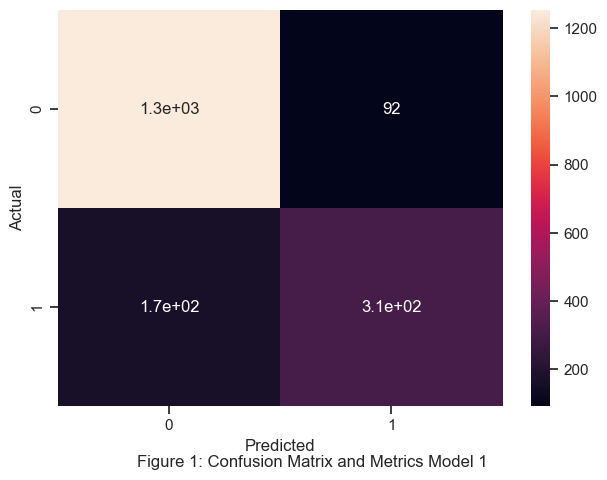

In [2701]:


# Calculate accuracy
accuracy = accuracy_score(Y_test,  Y_pred_log)
print(f"Accuracy of the model: {accuracy:.2f}")

from sklearn.metrics import log_loss

precision_micro = precision_score(Y_test, Y_pred_log, average='micro')
recall_micro = recall_score(Y_test,Y_pred_log, average='micro')
r2 = r2_score(Y_test, Y_pred_log)
mse = mean_squared_error(Y_test, Y_pred_log)
model_log_loss = log_loss(Y_test, Y_pred_log)



print(f'Micro Precision: {precision_micro}')
print(f'Micro Recall: {recall_micro}')
print(f'r2: {r2}')
print(f'mse: {mse}')
print(f'bic: {Model_1[0].bic}')
print(f'logloss: {model_log_loss}')

# Display confusion matrix
confusion_matrix = pd.crosstab(Y_test['hospdead'], Y_pred_log.flatten(), rownames=['Actual'], colnames=['Predicted'])
sn.heatmap(confusion_matrix, annot=True)

txt="Figure 1: Confusion Matrix and Metrics Model 1"
plt.figtext(0.5, 0.01, txt, wrap=True, horizontalalignment='center', fontsize=12)
plt.tight_layout()
plt.show()

#### 3.3 Preliminary Model 1 Implementation: K-fold cross validation

I also performed k-fold cross validation with 10 folds for comparison with the test set in order to add more rigour to the model evaluation.

In [2704]:
# Define number of folds
k = 10

# Initialize a KFold object
kf = KFold(n_splits=k)

# Initialize lists to store accuracy for each fold

X_kfold=X3.copy().to_numpy()
y_kfold=Y.copy().to_numpy()

accuracy_scores = []

# Perform k-fold cross-validation
for train_index, test_index in kf.split(X_kfold):
    X_train, X_test = X_kfold[train_index], X_kfold[test_index]
    y_train, y_test = y_kfold[train_index], y_kfold[test_index]
    #X_train, y_train = X_kfold[train_index], y_kfold[train_index]
    #X_test, y_test = X_kfold[test_index], y_kfold[test_index]

    # Create and train model
    
    
    
    model_log = LogisticRegression(max_iter=500)
    logistic_fit=model_log.fit(X_train, y_train.ravel())

    # Predict on the testing set
    Y_pred_log = np.round(model_log.predict(X_test)) # rounded
    
    accuracy = accuracy_score(y_test, Y_pred_log)

    accuracy_scores.append(accuracy)
    

# Calculate and store the mean R-squared and mean MSE scores for this value of k
mean_accuracy = np.mean(accuracy_scores)


print(f"Mean K-fold Cross Validation Accuracy Score: {mean_accuracy}")


Mean K-fold Cross Validation Accuracy Score: 0.8928051531344616


I find above in Figure 1, that Model 1 has a validation set accuracy of 0.85, relatively high. In addition the micro precision and recall each at 0.85 also relatively high. 
As noted earlier, since we have a class imbalance (insofar as there are much more patients that do not die than do) I am using micro as opposed to the other measures (i.e no weighted or macro etc).


## 4 Data Exploration

My main aim here was to determine whether the features used were actually independant, also to uncover any interesting interactions or relationships that were not earlier apparent as well as establish extent of relationship with dependant variable hospital deaths ('hospdead').

In [2708]:
#create new dataframe including only the coefficients that were statistically sig. in Model 1

X3=X3[['age','scoma','charges','totcst','avtisst','sps','aps','hday','adlsc', 'race_black','dnr_dnr after sadm','dnr_dnr before sadm','dzgroup_ARF/MOSF w/Sepsis', 'dzgroup_CHF', 'dzgroup_COPD', 'dzgroup_Cirrhosis', 'dzgroup_Colon Cancer', 'dzgroup_Coma', 'dzgroup_Lung Cancer', 'dzgroup_MOSF w/Malig'
]]

X3




,age,scoma,charges,totcst,avtisst,sps,aps,hday,adlsc,race_black,dnr_dnr after sadm,dnr_dnr before sadm,dzgroup_ARF/MOSF w/Sepsis,dzgroup_CHF,dzgroup_COPD,dzgroup_Cirrhosis,dzgroup_Colon Cancer,dzgroup_Coma,dzgroup_Lung Cancer,dzgroup_MOSF w/Malig
0,0.534663,0.00,0.005958,0.048682,0.073171,0.340431,0.139860,0.000000,0.989645,0,0,0,0,0,0,0,0,0,1,0
1,0.504702,0.44,0.023236,0.048682,0.341463,0.530323,0.517483,0.013605,0.141378,0,0,0,0,0,0,1,0,0,0,0
2,0.414111,0.00,0.027837,0.048682,0.146341,0.205077,0.314685,0.020408,0.000000,0,0,0,0,0,0,1,0,0,0,0
3,0.290468,0.00,0.001329,0.048682,0.073171,0.201012,0.132867,0.000000,0.000000,0,0,0,0,0,0,0,0,0,1,0
4,0.737930,0.26,0.034135,0.048682,0.215447,0.235383,0.209790,0.013605,0.282756,0,0,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9100,0.573122,0.00,0.036047,0.054215,0.235772,0.162615,0.153846,0.081633,0.000000,0,0,0,1,0,0,0,0,0,0,0
9101,0.442832,0.41,0.023851,0.037205,0.207317,0.258587,0.216783,0.000000,0.000000,0,0,0,0,0,0,0,0,1,0,0
9102,0.624537,0.00,0.031651,0.049603,0.268293,0.227294,0.272727,0.115646,0.357034,0,0,0,1,0,0,0,0,0,0,0
9103,0.345775,0.00,0.039930,0.048682,0.420732,0.404044,0.356643,0.142857,0.000000,0,1,0,0,0,0,0,0,0,0,1


### 4.1 Data Exploration: Distributions and Testing for Normality

In [2710]:
#### 4.1.1 Data Exploration: Distributions and Testing for Normality: Dependant Variable

In [2711]:
X_correlation=X3.copy()
X_correlation['hospdead']=Y['hospdead']

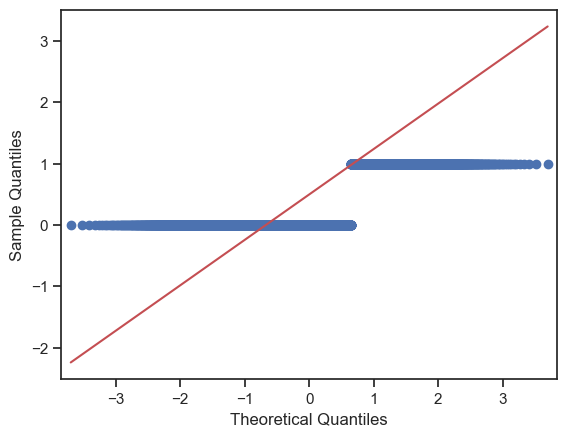

In [2712]:
#there isn't much to say here other than that there is a clear class imbalance which was identified before
#this will be accounted for during model evaluation by using micro measures for recall and precision
sm.qqplot(X_correlation['hospdead'], line='q')
plt.show()

#### 4.1.2 Data Exploration: Distributions and Testing for Normality: Features

/Users/neilwatt/opt/anaconda3/lib/python3.9/site-packages/statsmodels/graphics/utils.py:55: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = plt.figure()


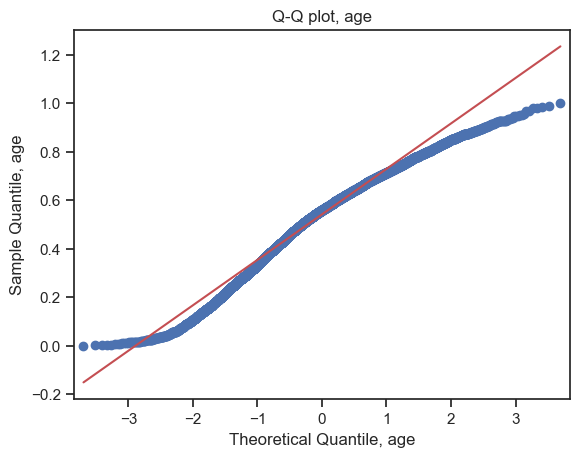

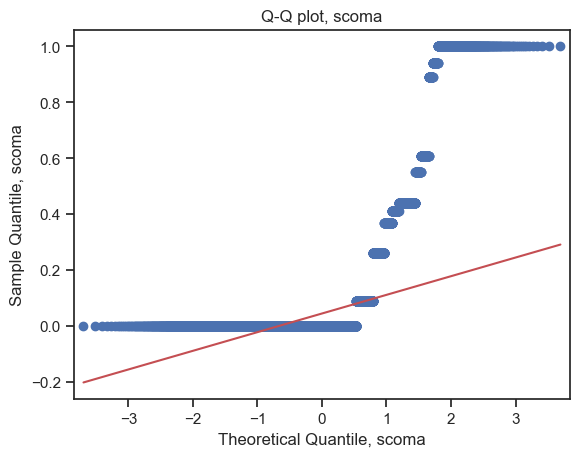

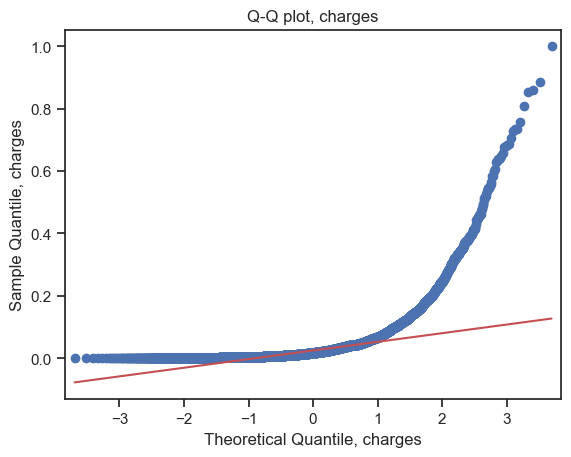

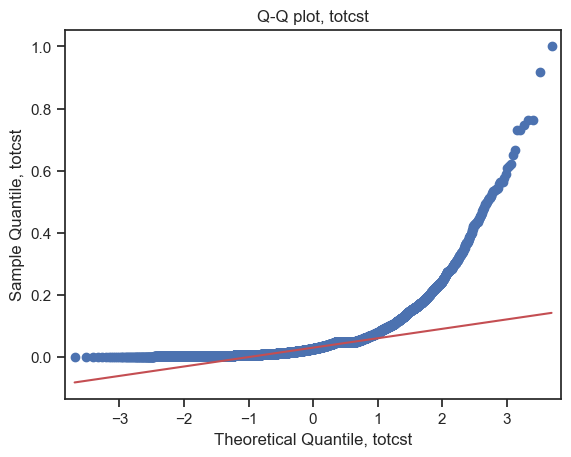

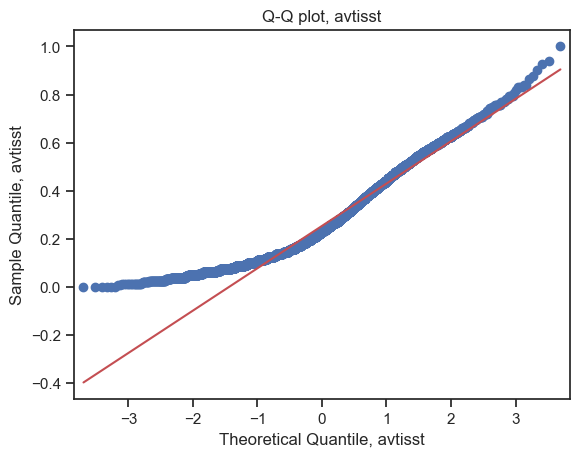

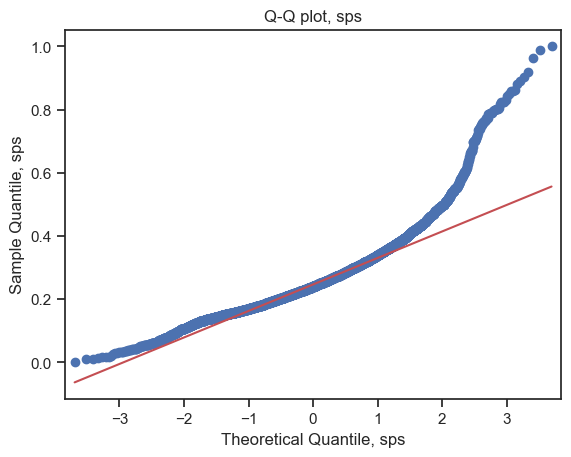

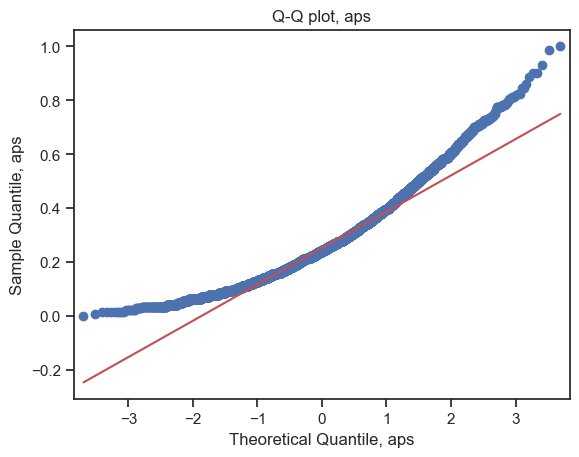

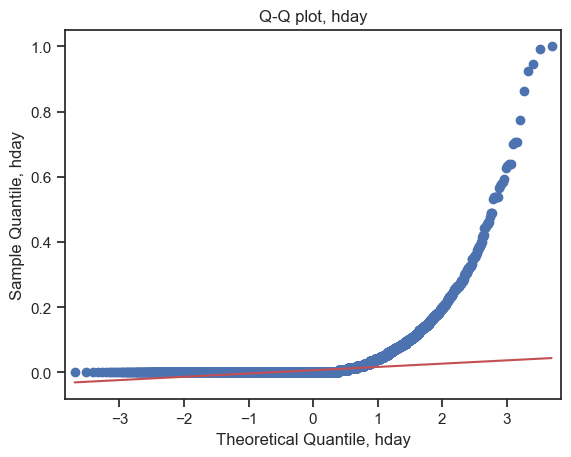

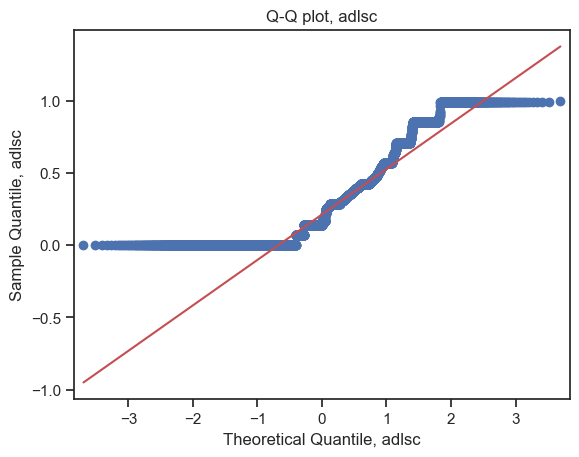

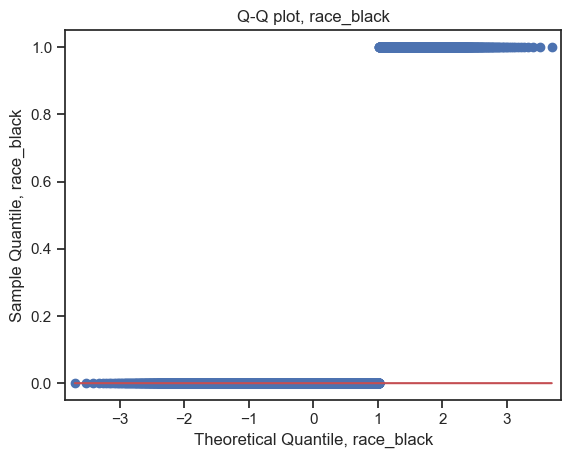

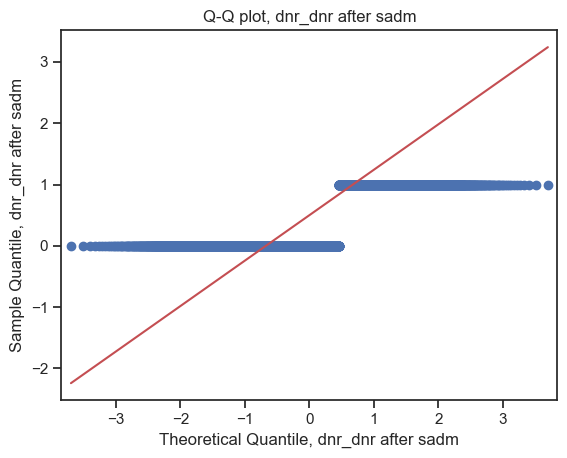

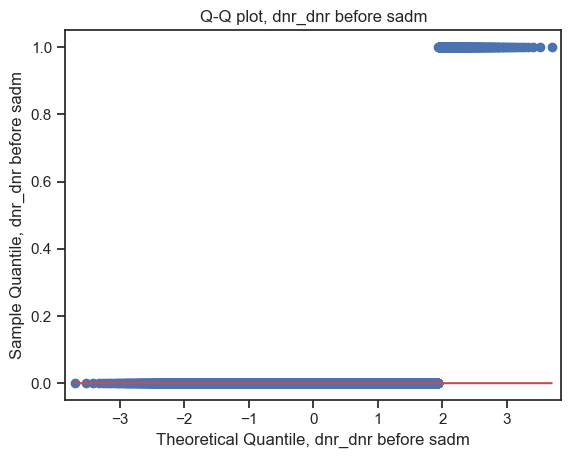

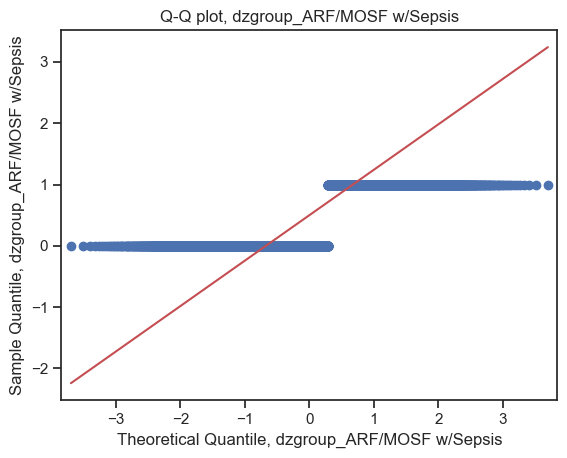

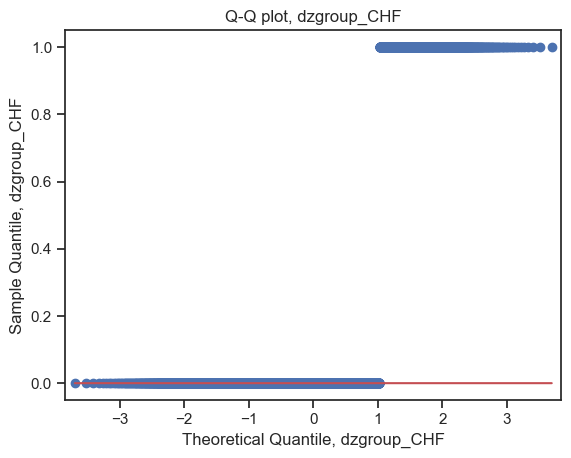

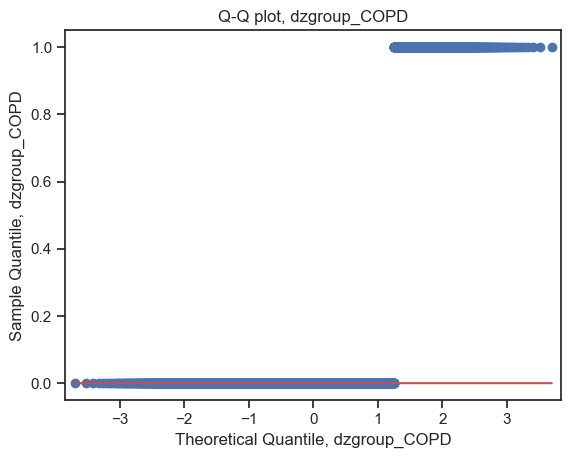

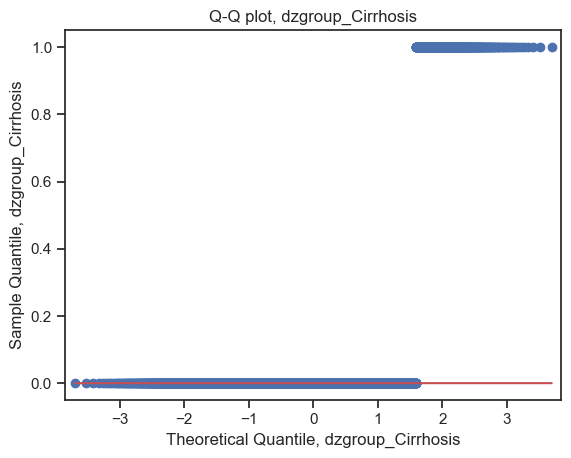

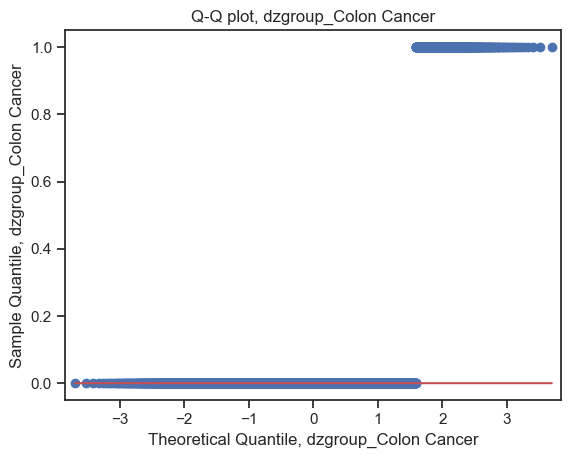

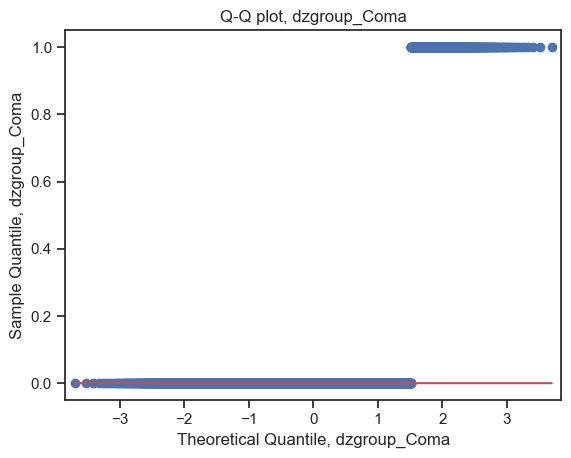

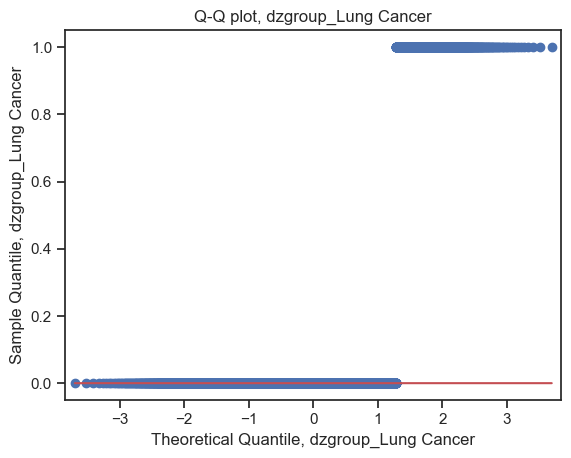

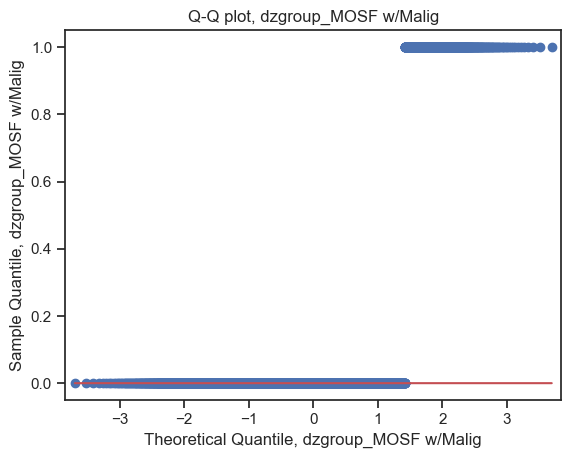

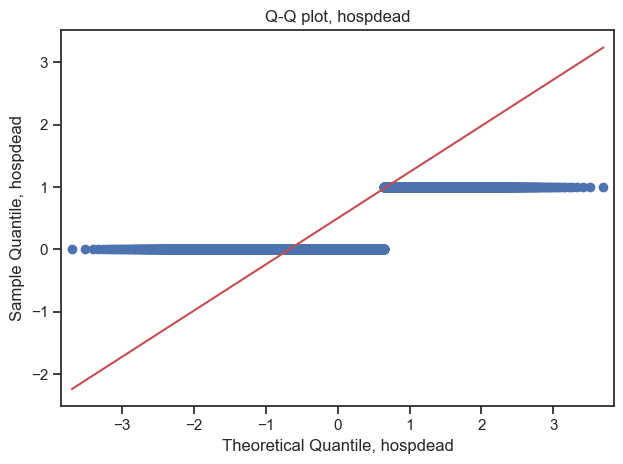

In [2714]:

for e, col_name in enumerate(X_correlation.columns):     
    
    #ax_l[e].scatter( X_correlation[col_name], X_correlation.hospdead,alpha=0.025, color='b')
    
    
    sm.qqplot(X_correlation[col_name] , line='q')
    plt.title(f'Q-Q plot, {col_name}')
    plt.xlabel(f'Theoretical Quantile, {col_name}')
    plt.ylabel(f'Sample Quantile, {col_name}')
   
    

    
plt.tight_layout() 

Some observations that are made upon reviewing the distribution plots above.

With regard to the continous variables the following observations were made:
Age: mostly normal with deviations from normality at upper 2-3 quantiles, and lower -3 quartile.
I proceeded to make a log transformation.

Scoma. Most values just below zero and also just over 3 almost like a step function with some outliers in between.

Totcst. Clear deviation at 2 quartiles exponentiates, consider *** transform.

Avtisst. Clear deviation at lower -2 and -3 quartiles where it flattens otherwise mostly linear especially at higher values, consider *** transform.

Adlsc. Linear between -1 and 2 quartiles but huge numbers of variables at just below zero and also around 2 means there is a kind of step function at either extremes. 

With regard to the categorical variables the following observations were made.:
Race_black, we see a class/category imbalance here but it is not dramatic.
Drn after sadm (do not recussitate order after admission) is almost evenly distributed according to 0 and 1.
In case of dnr after sadm and MOSF w/Malig we see only a very small percentage of the dataset are positive for this. Given we have found that both are statistically significant and substantial in their effect it is worth considering how this may affect the model.

The other categorical features were relatively balanced in comparison.





In [2716]:
X3.describe()

,age,scoma,charges,totcst,avtisst,sps,aps,hday,adlsc,race_black,dnr_dnr after sadm,dnr_dnr before sadm,dzgroup_ARF/MOSF w/Sepsis,dzgroup_CHF,dzgroup_COPD,dzgroup_Cirrhosis,dzgroup_Colon Cancer,dzgroup_Coma,dzgroup_Lung Cancer,dzgroup_MOSF w/Malig
count,9105.000000,9105.000000,9105.000000,9105.000000,9105.000000,9105.000000,9105.000000,9105.000000,9105.000000,9105.000000,9105.000000,9105.000000,9105.000000,9105.000000,9105.000000,9105.000000,9105.000000,9105.000000,9105.000000,9105.000000
mean,0.532287,0.120572,0.041016,0.048682,0.263548,0.255849,0.262923,0.023129,0.266960,0.152773,0.324657,0.026249,0.386052,0.152334,0.106205,0.055794,0.056233,0.065459,0.099725,0.078199
std,0.186069,0.246357,0.070890,0.068683,0.160653,0.100001,0.139180,0.062087,0.283288,0.359789,0.468272,0.159885,0.486869,0.359364,0.308117,0.229535,0.230383,0.247347,0.299650,0.268499
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.414708,0.000000,0.006116,0.010378,0.134146,0.189923,0.160839,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.558612,0.000000,0.017176,0.027325,0.228659,0.239409,0.237762,0.000000,0.141378,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.667697,0.090000,0.043480,0.051239,0.371951,0.303061,0.342657,0.013605,0.424134,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [2717]:

X3_transform=X3.copy()

#log transformations for age, totcst, charges, avtisst, hday, aps, sps
X3_transform['age'] = np.log(X3_transform['age'])
X3_transform['totcst'] = np.log(X3_transform['totcst'])
X3_transform['charges'] = np.log(X3_transform['charges'])
X3_transform['avtisst'] = np.log(X3_transform['avtisst'])
X3_transform['hday'] = np.log(X3_transform['hday'])
X3_transform['aps'] = np.log(X3_transform['aps'])
X3_transform['sps'] = np.log10(X3_transform['sps'])





/Users/neilwatt/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/neilwatt/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


/Users/neilwatt/opt/anaconda3/lib/python3.9/site-packages/statsmodels/graphics/gofplots.py:918: RuntimeWarning: invalid value encountered in subtract
  b = q25 - m * theoretical_quartiles[0]
/Users/neilwatt/opt/anaconda3/lib/python3.9/site-packages/statsmodels/graphics/gofplots.py:919: RuntimeWarning: invalid value encountered in multiply
  ax.plot(x, m * x + b, **lineoptions)


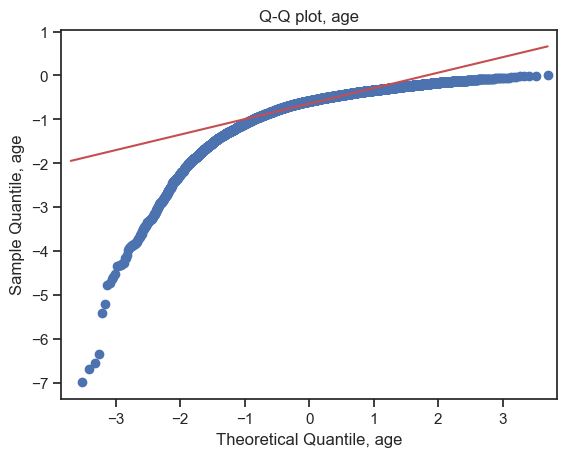

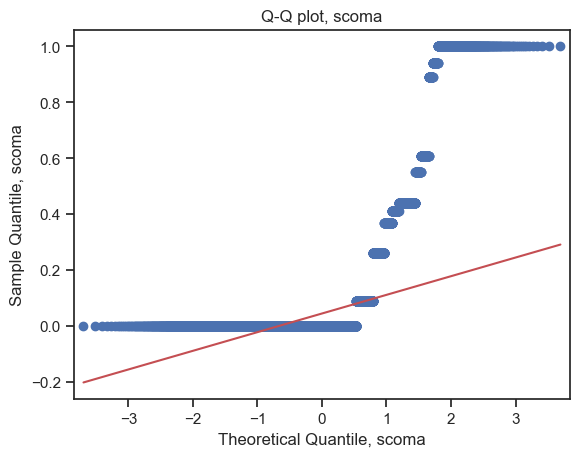

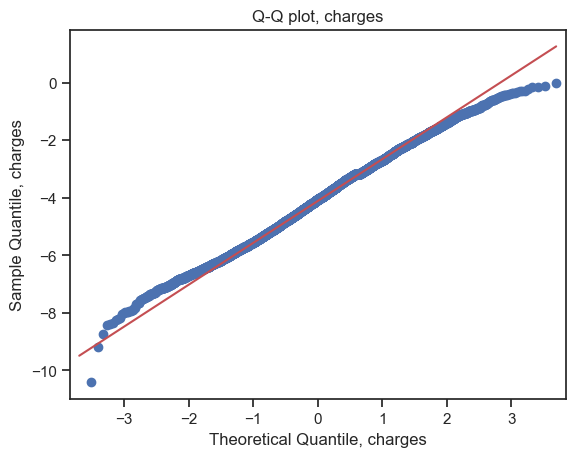

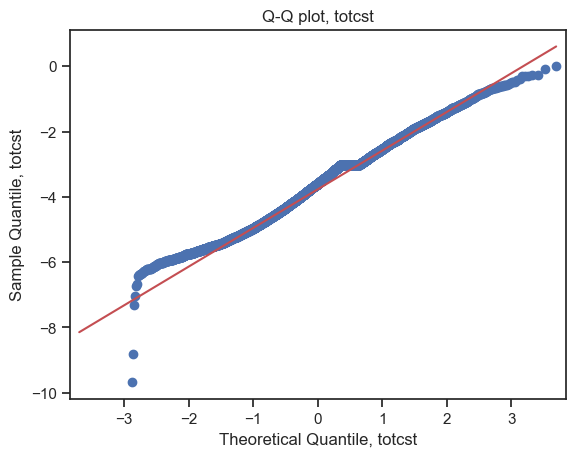

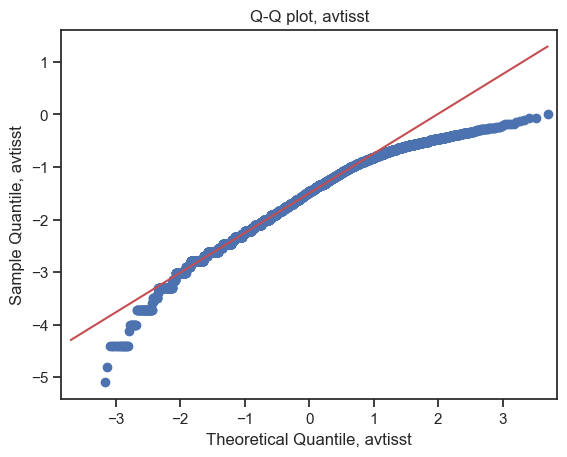

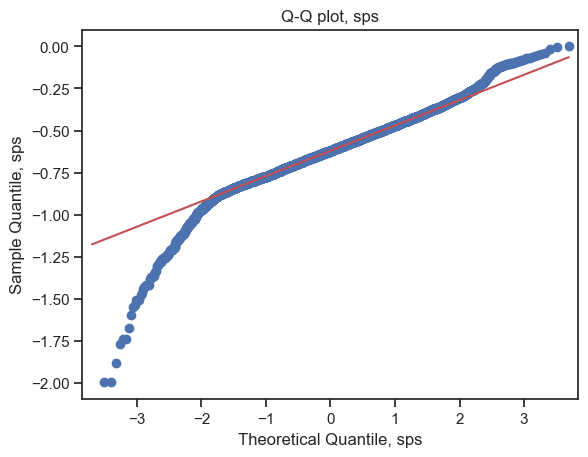

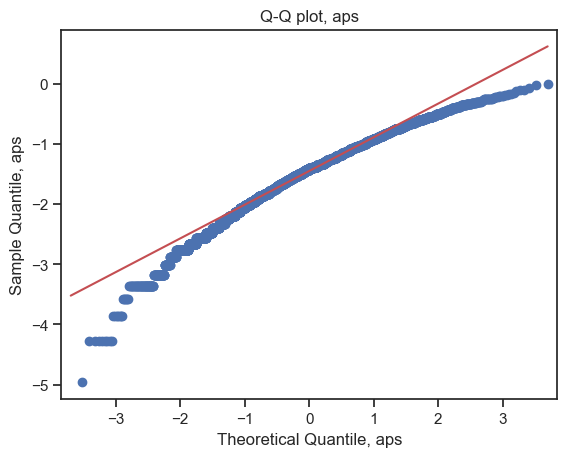

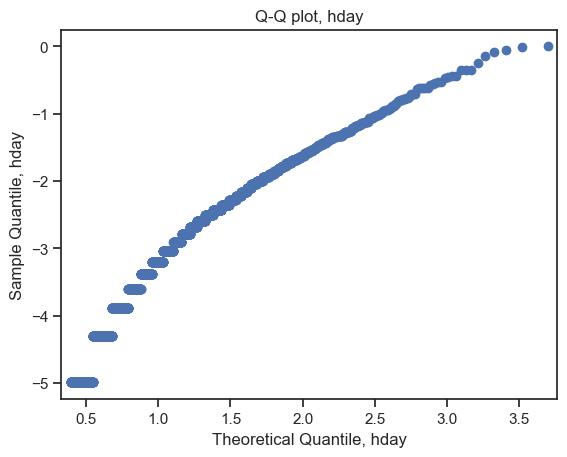

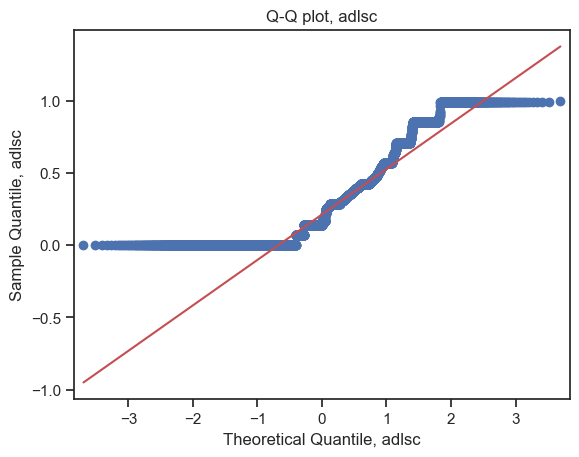

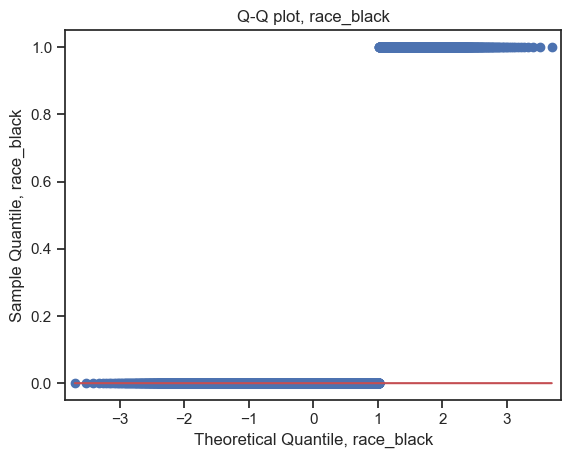

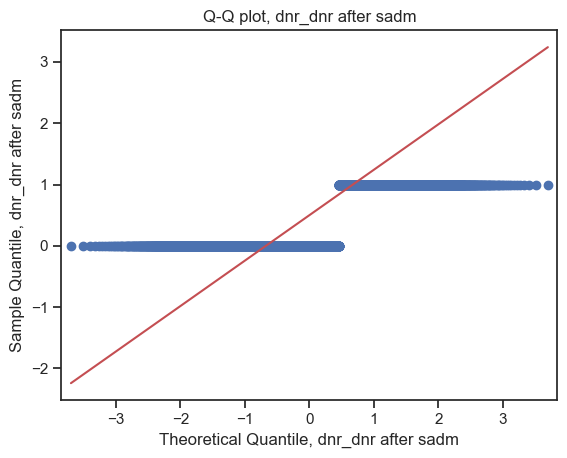

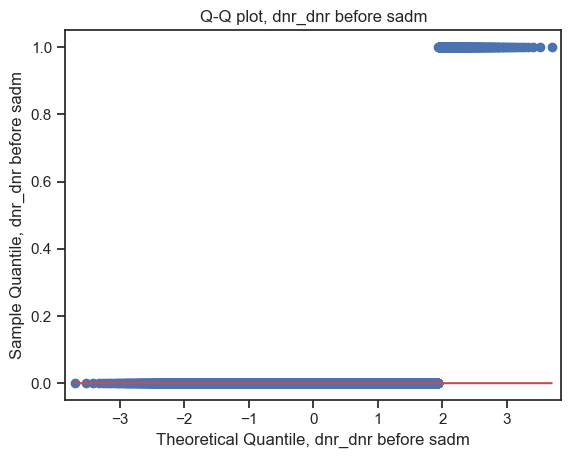

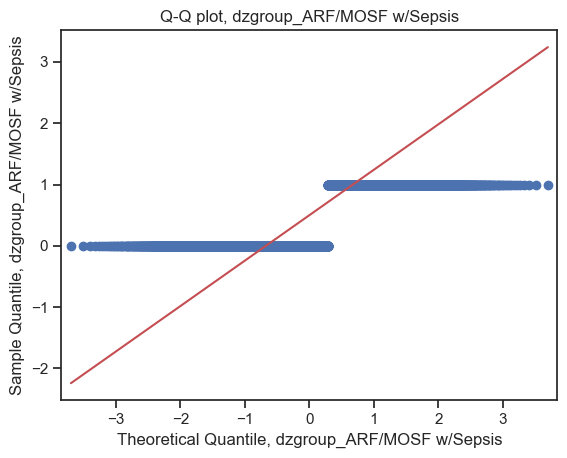

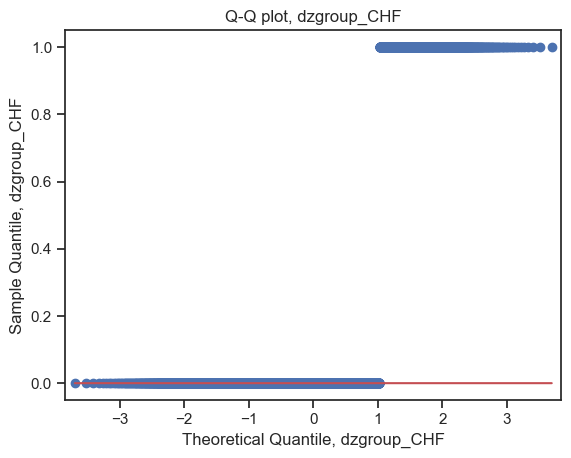

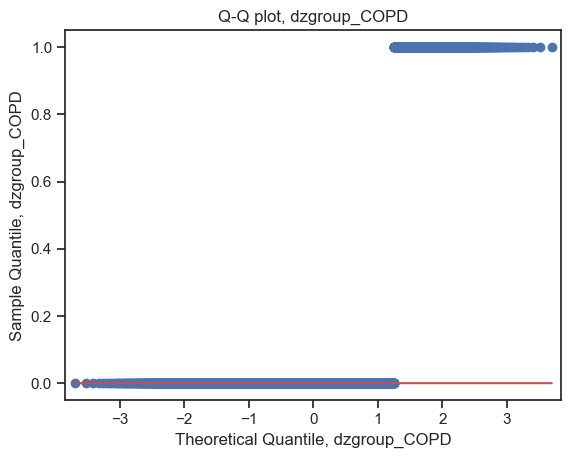

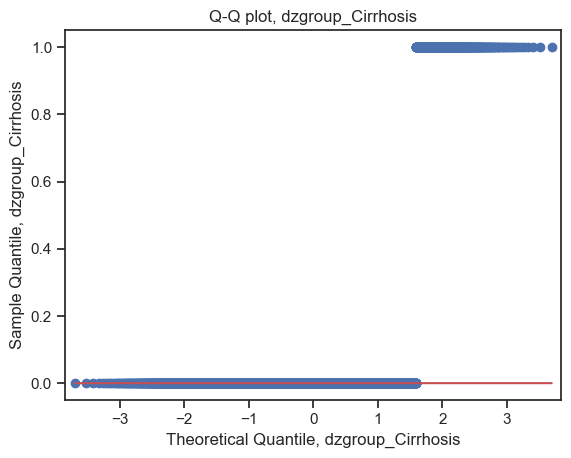

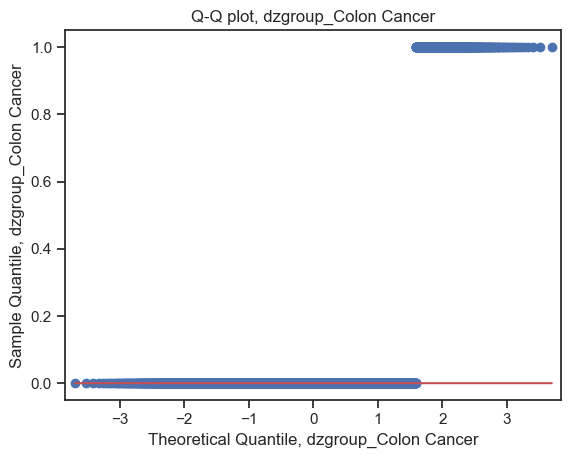

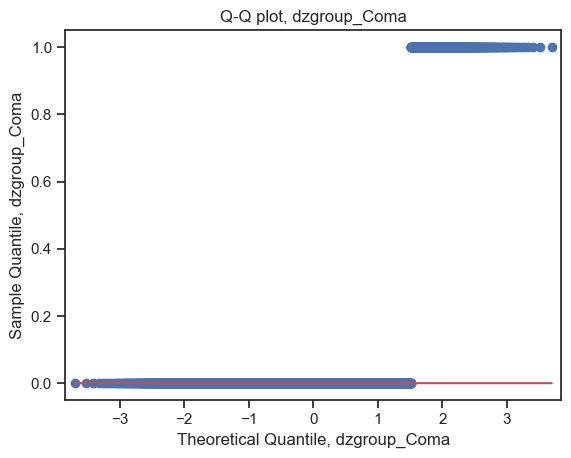

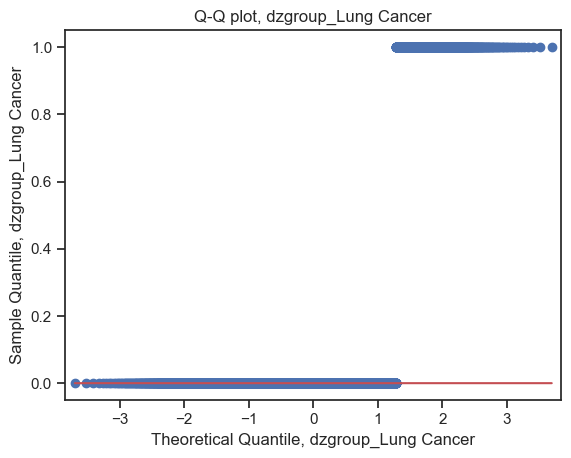

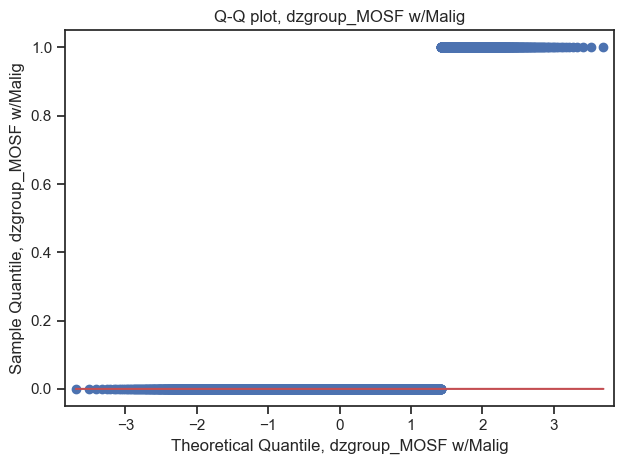

In [2718]:

#in order to confirm I re-plot with the transformations
#I decide that hday, charges, totcst should retain the transformation
#while I should keep age, avtisst, sps and aps as was previous

for e, col_name in enumerate(X3_transform.columns):     
    
    #ax_l[e].scatter( X_correlation[col_name], X_correlation.hospdead,alpha=0.025, color='b')
    
    
    sm.qqplot(X3_transform[col_name] , line='q')
    plt.title(f'Q-Q plot, {col_name}')
    plt.xlabel(f'Theoretical Quantile, {col_name}')
    plt.ylabel(f'Sample Quantile, {col_name}')
   
    

    
plt.tight_layout() 

In [2719]:
#retaining log transformations for totcst, charges, hday. 
#Reverting to earlier original data for the others that had earlier log transformed

X3['totcst'] = np.log(X3['totcst'])
X3['charges'] = np.log(X3['charges'])
X3['hday'] = np.log(X3['hday'])



In [2720]:
#there was a step function like pattern for scoma and adlsc decide to mapp these to 0 and 1 categorical variables according to whether below 0.5 or now
#given vast majority of values fall at the extremes
X3['scoma']=X3['scoma'].round()
X3['adlsc']=X3['adlsc'].round()




### 4.1 Data Exploration: Correlation Matrix
My first step here was to use a correlation matrix to check for possible dependancies between the feature variables as well as a correlation table of the independant variables and dependant variables.

Relationships between features would violate the assumption of independence which would affect the intepretability and robustness of any models particularly logistic regression models developed using these variables. In cases where the assumption of independance was violated decisions on which variables to include and exclude were made based on their relationship with the dependant variable according to the pearson correlation and visually from various scatterplots as appropriate.

In [2722]:
#create correlation matrix to help check for independance of coefficients
#corr = X3.corr()
#corr.style.background_gradient(cmap='coolwarm').set_precision(2)

corr = X3.corr()
corr.style.background_gradient(cmap='coolwarm').set_precision(2)



/var/folders/2t/dswlrlgs7r55b7gdz46sp2hc0000gn/T/ipykernel_94948/1576245936.py:6: FutureWarning: this method is deprecated in favour of `Styler.format(precision=..)`
  corr.style.background_gradient(cmap='coolwarm').set_precision(2)


,age,scoma,charges,totcst,avtisst,sps,aps,hday,adlsc,race_black,dnr_dnr after sadm,dnr_dnr before sadm,dzgroup_ARF/MOSF w/Sepsis,dzgroup_CHF,dzgroup_COPD,dzgroup_Cirrhosis,dzgroup_Colon Cancer,dzgroup_Coma,dzgroup_Lung Cancer,dzgroup_MOSF w/Malig
age,1.00,0.00,-0.18,-0.18,-0.13,-0.12,-0.03,0.02,0.11,-0.13,0.17,0.13,-0.08,0.11,0.16,-0.14,-0.01,0.04,-0.01,-0.08
scoma,0.00,1.00,0.06,0.06,0.19,0.19,0.17,0.00,0.05,0.04,0.22,0.02,-0.04,-0.11,-0.08,-0.04,-0.07,0.57,-0.09,-0.02
charges,-0.18,0.06,1.00,0.92,0.64,0.39,0.44,0.45,0.02,-0.01,0.16,-0.08,0.50,-0.27,-0.18,-0.07,-0.16,0.04,-0.29,0.13
totcst,-0.18,0.06,0.92,1.00,0.61,0.36,0.41,0.42,0.03,0.01,0.15,-0.08,0.48,-0.26,-0.17,-0.06,-0.14,0.05,-0.28,0.13
avtisst,-0.13,0.19,0.64,0.61,1.00,0.56,0.59,0.17,0.02,-0.00,0.28,-0.06,0.44,-0.26,-0.17,-0.09,-0.19,0.12,-0.28,0.17
sps,-0.12,0.19,0.39,0.36,0.56,1.00,0.80,0.15,0.07,0.02,0.28,0.00,0.28,-0.18,-0.13,0.01,-0.16,0.02,-0.20,0.22
aps,-0.03,0.17,0.44,0.41,0.59,0.80,1.00,0.20,0.08,0.03,0.30,0.00,0.33,-0.16,-0.11,0.01,-0.22,0.02,-0.30,0.23
hday,0.02,0.00,0.45,0.42,0.17,0.15,0.20,1.00,0.02,-0.08,0.14,0.02,0.00,-0.10,-0.04,-0.05,0.03,-0.01,-0.06,0.10
adlsc,0.11,0.05,0.02,0.03,0.02,0.07,0.08,0.02,1.00,0.04,0.13,0.09,0.05,-0.04,0.04,-0.00,-0.07,0.00,-0.03,0.02
race_black,-0.13,0.04,-0.01,0.01,-0.00,0.02,0.03,-0.08,0.04,1.00,-0.03,-0.03,0.02,0.05,-0.04,-0.02,-0.04,0.04,-0.03,0.00


*Figure 2: Correlation Matrix Independant Variables*

In [2724]:
X_correlation.corr()['hospdead']

age                          0.039354
scoma                        0.379427
charges                      0.185008
totcst                       0.180855
avtisst                      0.551099
sps                          0.462505
aps                          0.475781
hday                         0.213804
adlsc                        0.126350
race_black                   0.015644
dnr_dnr after sadm           0.568362
dnr_dnr before sadm          0.020461
dzgroup_ARF/MOSF w/Sepsis    0.140507
dzgroup_CHF                 -0.190073
dzgroup_COPD                -0.120110
dzgroup_Cirrhosis           -0.014931
dzgroup_Colon Cancer        -0.112835
dzgroup_Coma                 0.210294
dzgroup_Lung Cancer         -0.111548
dzgroup_MOSF w/Malig         0.177794
hospdead                     1.000000
Name: hospdead, dtype: float64

*Figure 3: Correlation Matrix Independant and Independant Variables*

From the heatmap/correlation matrix above in Figure 2 there are several observations from left to right:
* scoma has a high correlation (0.56) with dzcoma given they both relate to whether the patient has a coma and in case of scoma the severity of it, this is not surprising. When I plot both below ("Plot of scoma and DZ Coma category" in Figure 4) we see clearly that scoma is a better separator so I decide to drop dzgroup_Coma from X4.
* We can see a high correlation of 0.76 between totcst and charges. On plotting both below against hospital deaths in Figure 5 we see totcst is the better separator so I decide to drop charges even though it has a similar correlation with hospital deaths above in Figure 3.
* I see that sps has an extremely high correlation with aps, while they also have respectively a 0.56 and 0.59 correlation with avtisst. Avtisst has a significantly higher correlation with hospital deaths (0.55) in the table above and in the charts below appears to be a better separator (Figures 6-8) than sps or aps so I decide to drop aps and sps from the next dataframe.

At this point I decide to drop hday since it is correlated to both totcst and charges. In addition hday also appears to be a spurious value insofar as it's clearly more likely the longer before someone is admitted to the study (having not recovered and been released) then naturally the more likely it is that their costs would be higher and that they may have been admitted multiple times.




/Users/neilwatt/opt/anaconda3/lib/python3.9/site-packages/IPython/core/displayhook.py:281: UserWarning: Output cache limit (currently 1000 entries) hit.
Flushing oldest 200 entries.
  warn('Output cache limit (currently {sz} entries) hit.\n'


[Text(0.5, 1.0, 'Plot of scoma and DZ Coma category')]

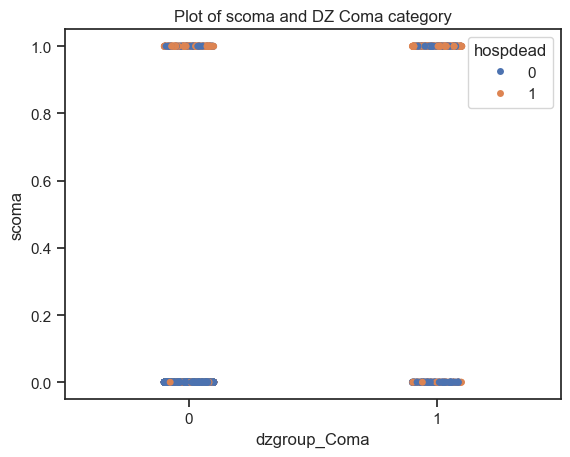

In [2727]:

ax = sns.stripplot(y=X3['scoma'], x=X3['dzgroup_Coma'],hue=Y['hospdead'])
ax.set(title="Plot of scoma and DZ Coma category")





*Figure 4: Plot of scoma and DZ Coma category*

<Axes: xlabel='hospdead', ylabel='totcst'>

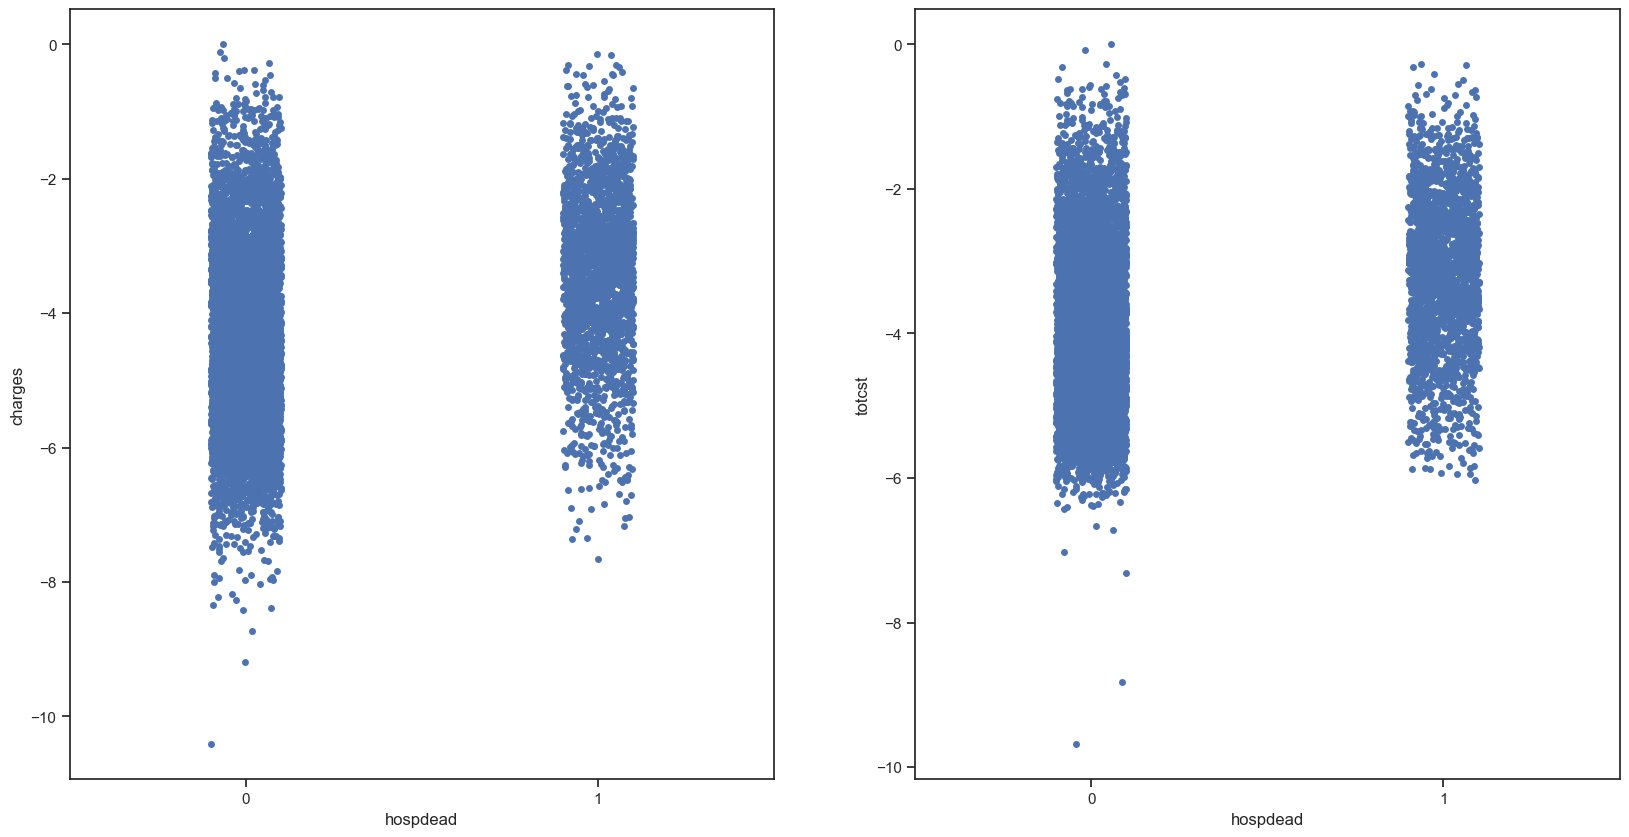

In [2729]:
#plot of hospital deaths against each of charges and totcst

fig, ax =plt.subplots(1,2,figsize=(20,10))

sns.stripplot(x=Y['hospdead'], y=X3['charges'],ax=ax[0])
sns.stripplot(x=Y['hospdead'], y=X3['totcst'], ax=ax[1])


*Figure 5: Plots of Hospital Deaths against charges and totcst*

[Text(0.5, 1.0, 'Plot of aps and sps Coma category')]

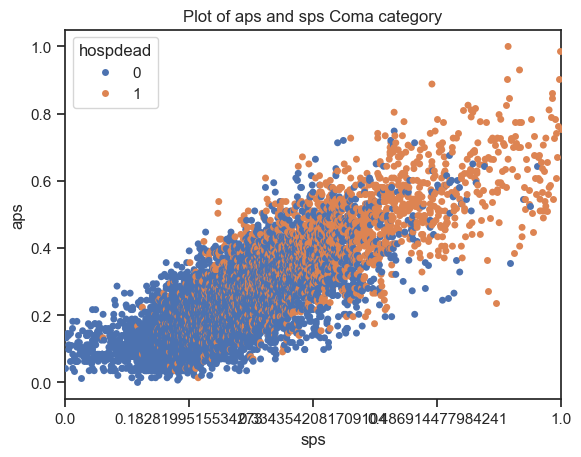

In [2731]:
ax = sns.stripplot(y=X3['aps'], x=X3['sps'],hue=Y['hospdead'])
ax.xaxis.set_major_locator(ticker.LinearLocator(5))
ax.set(title="Plot of aps and sps Coma category")

*Figure 6: Plot of asp and sps*

[Text(0.5, 1.0, 'Plot of aps and avtisst Coma category')]

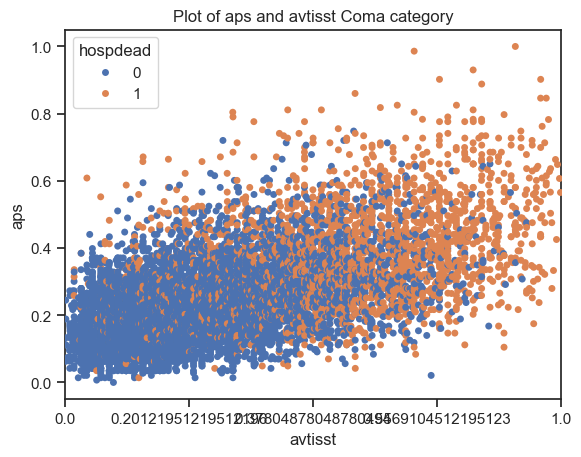

In [2733]:
ax = sns.stripplot(y=X3['aps'], x=X3['avtisst'],hue=Y['hospdead'])
ax.xaxis.set_major_locator(ticker.LinearLocator(5))
ax.set(title="Plot of aps and avtisst Coma category")

*Figure 7: Plot of asp and avtisst*

[Text(0.5, 1.0, 'Plot of avtisst and sps Coma category')]

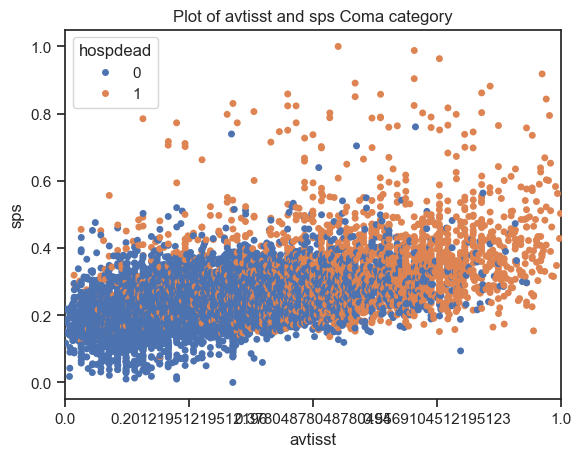

In [2735]:
ax = sns.stripplot(y=X3['sps'], x=X3['avtisst'],hue=Y['hospdead'])
ax.xaxis.set_major_locator(ticker.LinearLocator(5))
ax.set(title="Plot of avtisst and sps Coma category")

*Figure 8: Plot of sps and avtisst*

### 4.2 Data Exploration: Removing Redundant Columns

In [2738]:
#dropping column hday (days before patient admitted to study)
#at this point I disregard the relationships between hday and charges, hday and totcst
X4=X3.copy()
X4 = X4.drop('dzgroup_Coma', axis=1)
X4 = X4.drop('charges', axis=1)
X4 = X4.drop('hday', axis=1)
X4 = X4.drop('aps', axis=1)
X4 = X4.drop('sps', axis=1)

### 4.3 Data Exploration: Scatterplots of Related Independant Variables

To summarise the main conclusions from the exploratory analysis:
* Was determined to exclude hospital charges which had a 0.77 correlation with totcst. There is a very clear diagonal relationship between the two generally and also some other clearly linear patterns which would violate the independance assumptions, charges was found to be not as good a separator of hospital deaths vs survival as totcst.
* It may make sense to exclude APACHE III day 3 physiology score and (avtisst) given it's high correlation (0.59) with aps but less clear separation of hospital deaths than aps. Will experiement with including it (X4, model 2) and excluding it (X6, model 3).
* It may also make sense to exclude  totcst given it's apparent relationship with avtisst that would only make sense in cases where we are including avtisst.

### 4.4 Data Exploration: Boxplots of features and dependant variables
To help compare distributions of independant variables against dependant variable 'hospdead' hospital deaths boxplots are plotted below in Figure 9.

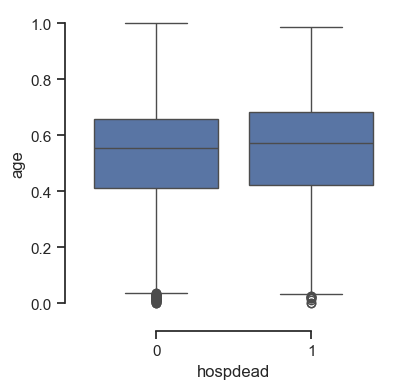

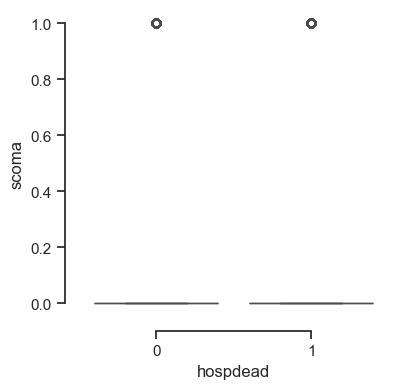

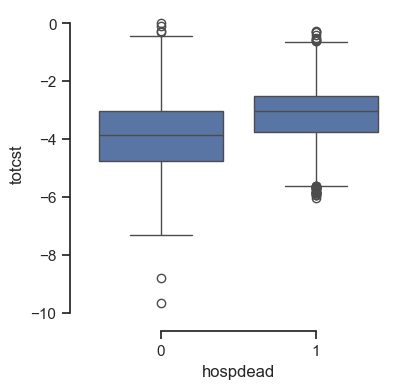

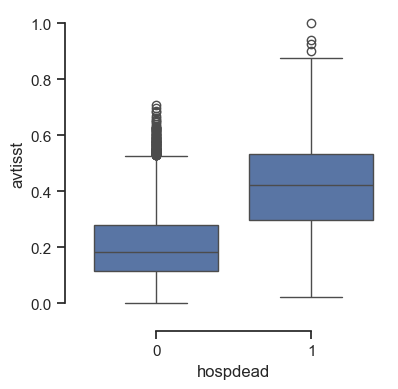

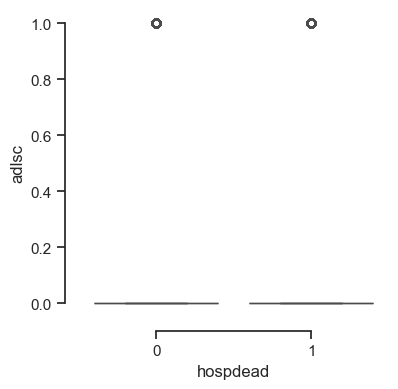

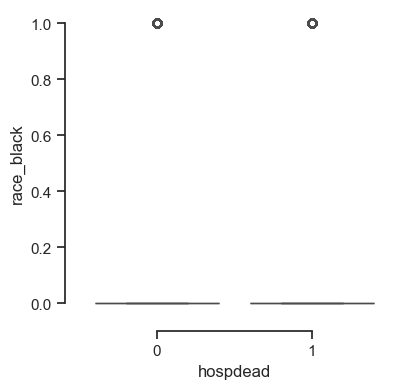

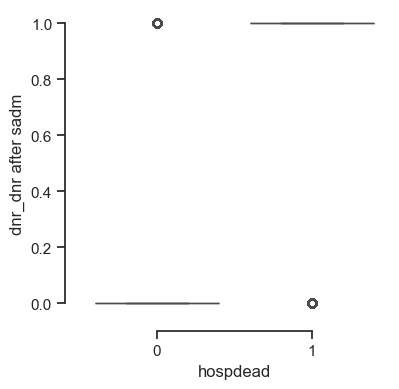

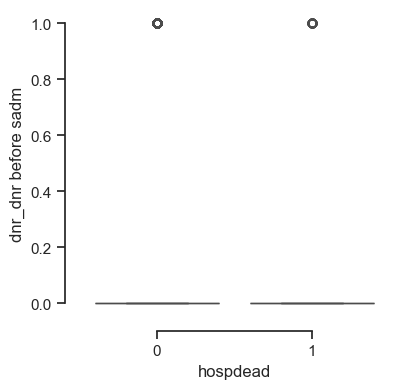

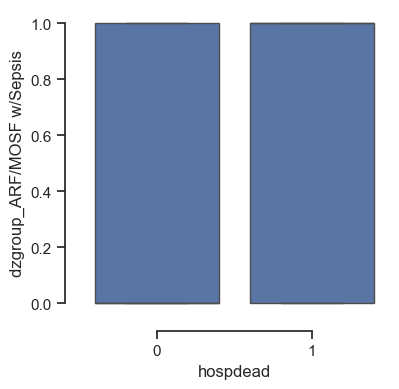

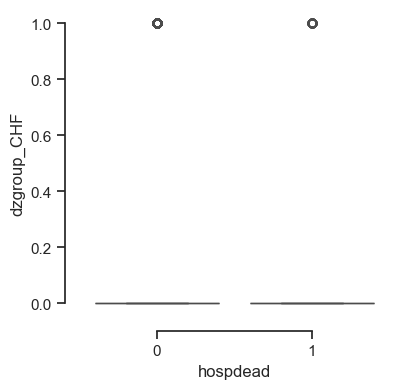

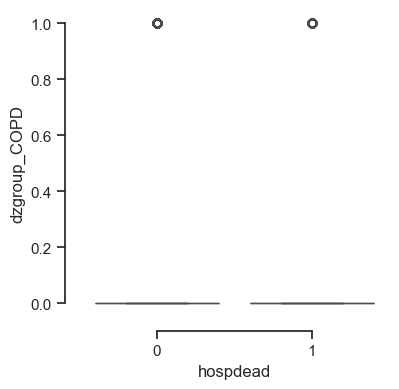

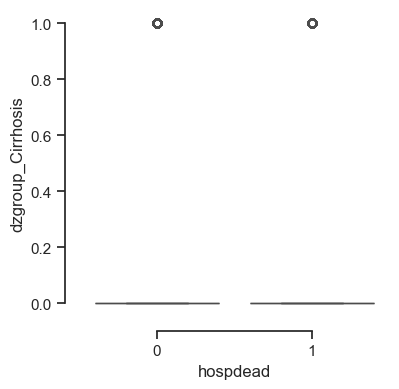

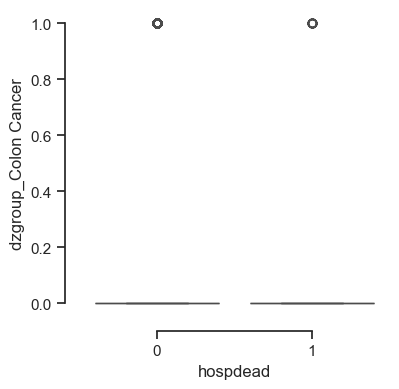

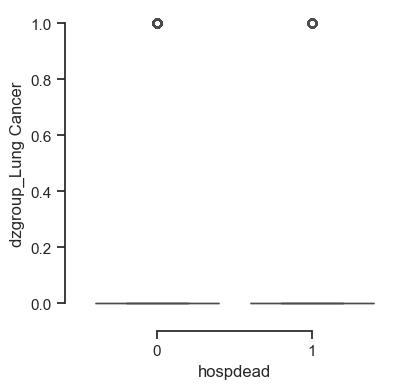

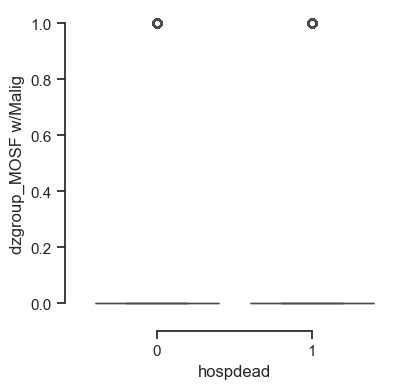

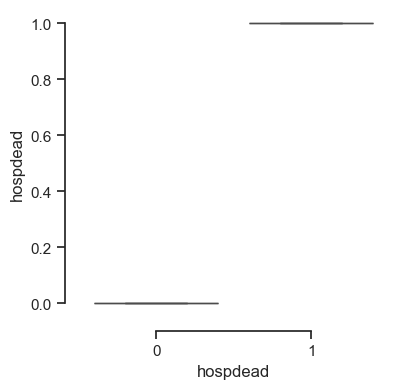

In [2742]:
X_correlation=X4.copy()
X_correlation['hospdead']=Y['hospdead']

#with hospital death/survival as x
for column in X_correlation.columns[0:]:  # Loop over all columns except 'Location'
    #sns.set()
    fig, ax = plt.subplots(figsize=(4, 4))
    #fig, ax = plt.subplots(figsize=(4, 4))
    sns.set(style="ticks")
    sns.boxplot(x='hospdead', y=column, data=X_correlation)  # column is chosen here
    sns.despine(offset=10, trim=True) 
    

  





I make the following observations from the boxplots in Figure 9 above:
* The relationship between age and mortality appears weakly positive with the mean age of dead patients higher than the survivors. We also can see a significant number of outliers in deaths around 20 in both survivors and dead patients.

* Relationship between scoma and hospital deaths is clearly positive although we can see a number of outliers in the survivors having multiple positive values.

* Weakly positive relationship between totcst and deaths but we see a large number of outliers in the case of survivors having in many cases extremely high costs. It is likely that this may need to be removed and, or, transformed. Wil consider proportion plot in case that bears out clearer results.

* There is a clear positive relationship between deaths and avtisst with median avtisst much higher in case of hospital deaths.

* Clear positive relationship between hospital deaths and adlsc although we see that the maximum adlsc values for both survivors and dead patients are similar the median is significantly higher in the case of the hospital deaths. 

* It is unclear whether there is any relationship between race_black and hospital deaths or not. It is possible that is in fact spurious. I note that the correlation was negligible (Figure 3 earlier in section 4.1). This is worth looking at as a proportion ratio plot before making any further decisions.

* The do not recussitate after admission (drn_drn_after_sadm) has a clear apparent positive relationship with deaths but I note we have outliers in the case of hospital deaths with many not having this value and many in the survivor group having this value.

* Dnr before admission (drn_drn_before_sadm) does not have a clear relationship with deaths from the chart alone and I note we have outliers in the case of hospital deaths with many not having this value and many in the survivor group having this value. As with race_black it is worth looking at as a proportion ratio plot before making any further decisions.

* None of the dzgroup, disease group classification, related plots showed any clear relationship with hospital deaths in the boxplots in Figure 9. However, I will-as with race_black, totcst and drn_drn_before_sadm- consider proportion plots before making further decisions on whether to include or remove these features from the training set.
 

### 4.5 Data Exploration: Scatterplots of features and dependant variables

In order to more fully examine the continuous features against hospital deaths, the dependant variable, scatterplots of all of the independant variables or features were plotted below in Figure 10. 

In [2745]:
X_correlation.head()

,age,scoma,totcst,avtisst,adlsc,race_black,dnr_dnr after sadm,dnr_dnr before sadm,dzgroup_ARF/MOSF w/Sepsis,dzgroup_CHF,dzgroup_COPD,dzgroup_Cirrhosis,dzgroup_Colon Cancer,dzgroup_Lung Cancer,dzgroup_MOSF w/Malig,hospdead
0,0.534663,0.0,-3.022451,0.073171,1.0,0,0,0,0,0,0,0,0,1,0,0
1,0.504702,0.0,-3.022451,0.341463,0.0,0,0,0,0,0,0,1,0,0,0,1
2,0.414111,0.0,-3.022451,0.146341,0.0,0,0,0,0,0,0,1,0,0,0,0
3,0.290468,0.0,-3.022451,0.073171,0.0,0,0,0,0,0,0,0,0,1,0,0
4,0.737930,0.0,-3.022451,0.215447,0.0,0,0,0,1,0,0,0,0,0,0,0


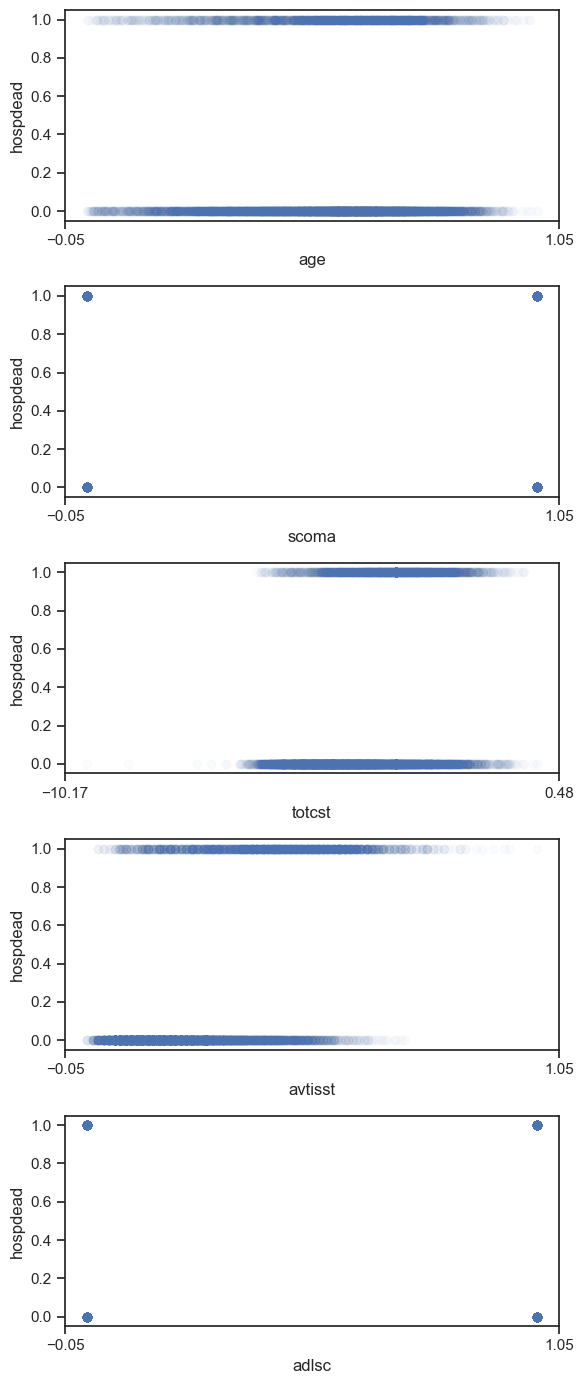

In [2746]:
import matplotlib.pyplot as plt 


f, ax_l = plt.subplots(5,1, figsize=(6, 14))


#note that here I am only including the continous variables
for e, col_name in enumerate(X_correlation.loc[:,:'adlsc' ].columns):    
    ax_l[e].scatter( X_correlation[col_name], X_correlation.hospdead,alpha=0.025, color='b')
    ax_l[e].set_xlabel(col_name)
    ax_l[e].set_ylabel('hospdead')
    ax_l[e].xaxis.set_major_locator(ticker.LinearLocator(2))
    
plt.tight_layout() 

*Figure 10: Scatterplots of Features and Hospital Deaths*

I observe in the above scatter charts:
* We see a lower density of deaths among lower age group but in the older age groups it is less clear, at the extremes of age we actually observe a lower density of deaths but it is not as clear as the survivability in younger patients. 

* Relationship between scoma and hospital deaths is unclear from the chart. 

* We see somewhat of a relationship between extremes of totcst and hospital death but as was pointed out also in the boxplot the relationship is unclear. Consider at this stage removing totcst to see if it improves resuls, recall also that from Figure (correlation table) that totcst had a small but significant correlation (0.46) with avtisst which was undoubtedly a better classifier than totcst (i.e correlation of 0.55 with hospital deaths compared to 0.18 with totcst).

* There appears to be a clear separation of hospital deaths at high avtisst levels and survival more likely at lower avtisst levels but the former is more clearly apparent.

* Relationship between adlsc and hospital deaths is unclear from the plot.


#### 4.6 Data Exploration: Countplots select features again dependant variable 

Here I carry out percent countplots on the categorical variables which had an unclear relationship with hospital deaths including race_black (race) and the dzgroup (disease categorisations) variables.
Since the other categorical variables were already found to have a clear relationship with hospital deaths or- as in the case of totcst was ruled out, I do not plot them again here.

<Axes: xlabel='race_black'>

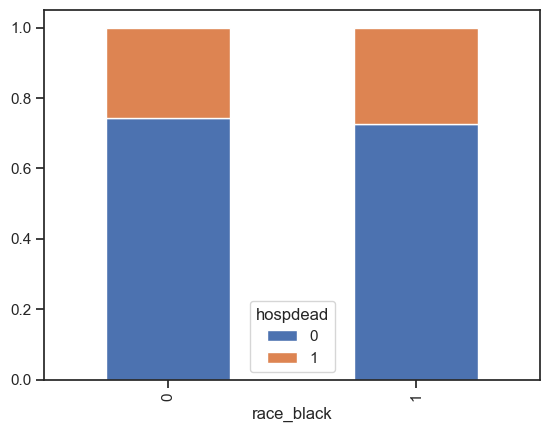

In [2751]:

#in plotting race against mortality, we observe marginally higher mortality in race_black =1 (i.e race black) than when that is not the case
pd.crosstab(X_correlation['race_black'],X_correlation['hospdead'],normalize='index').plot.bar(stacked=True)


*Figure 11: Plot of race_black (race category black) against hospital deaths.*

<Axes: xlabel='dnr_dnr before sadm'>

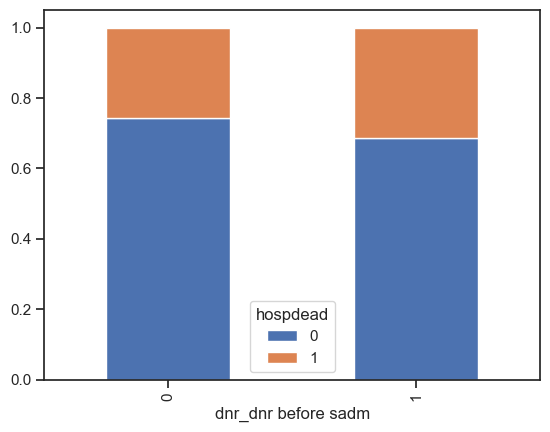

In [2753]:
#countplot (percent) of dnr before admission and hospital deaths
#we see that there is a higher mortality in the dnr before sadm than when that is not the case

pd.crosstab(X_correlation['dnr_dnr before sadm'],X_correlation['hospdead'],normalize='index').plot.bar(stacked=True)


*Figure 12: Plot of DNR( Do Not Resuscitate) Order before admission against Hospital Deaths*

<Axes: xlabel='dzgroup_MOSF w/Malig'>

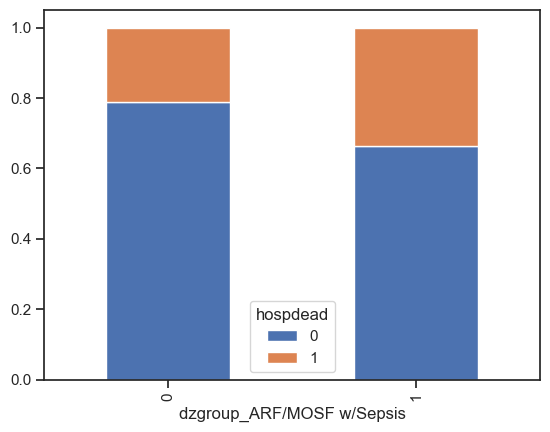

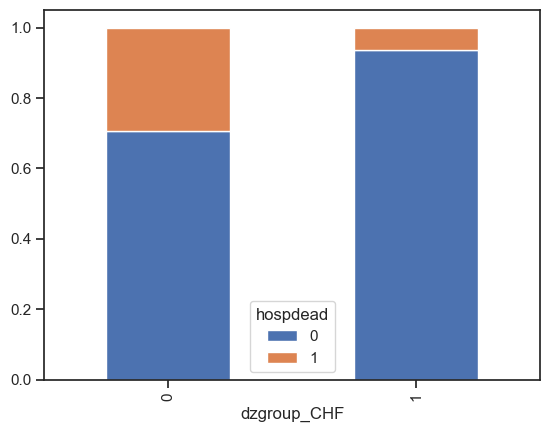

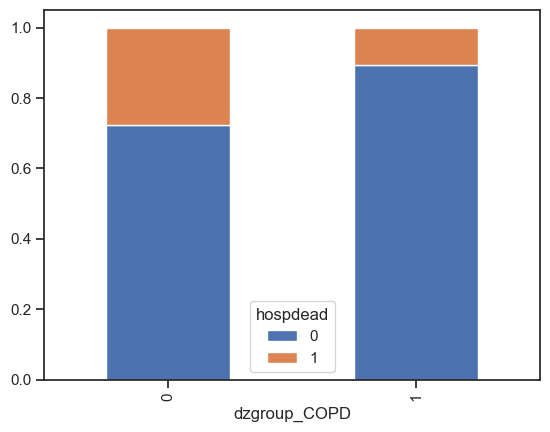

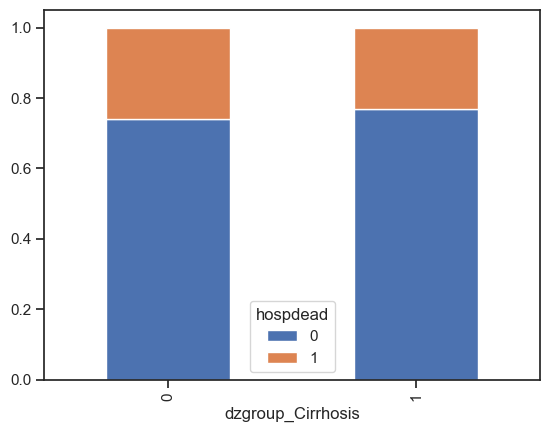

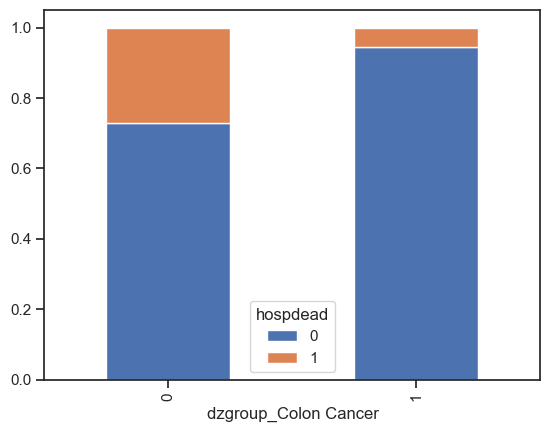

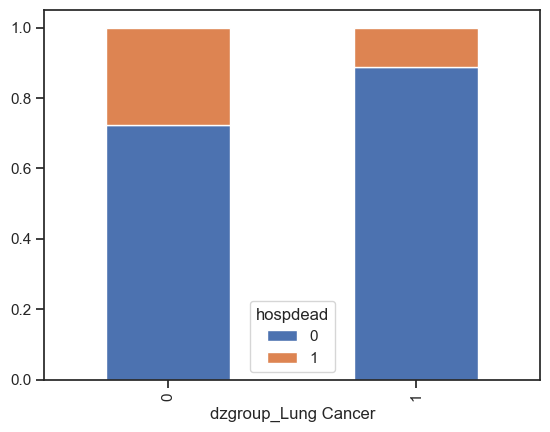

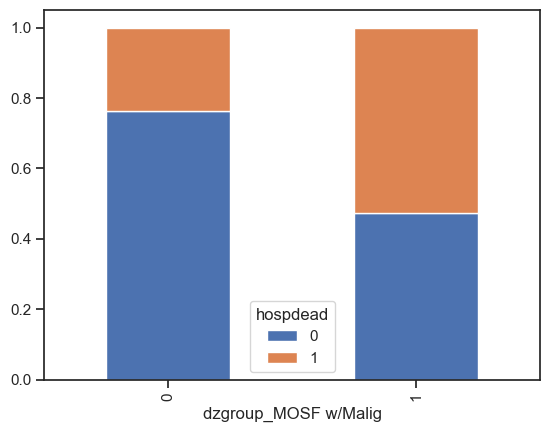

In [2755]:


#plot crosstabs of DZ categories (recall I had removed the coma category earlier as it was foudn redundant with scoma)


pd.crosstab(X_correlation['dzgroup_ARF/MOSF w/Sepsis'],X_correlation['hospdead'],normalize='index').plot.bar(stacked=True)
pd.crosstab(X_correlation['dzgroup_CHF'],X_correlation['hospdead'],normalize='index').plot.bar(stacked=True)
pd.crosstab(X_correlation['dzgroup_COPD'],X_correlation['hospdead'],normalize='index').plot.bar(stacked=True)
pd.crosstab(X_correlation['dzgroup_Cirrhosis'],X_correlation['hospdead'],normalize='index').plot.bar(stacked=True)
pd.crosstab(X_correlation['dzgroup_Colon Cancer'],X_correlation['hospdead'],normalize='index').plot.bar(stacked=True)
pd.crosstab(X_correlation['dzgroup_Lung Cancer'],X_correlation['hospdead'],normalize='index').plot.bar(stacked=True)
pd.crosstab(X_correlation['dzgroup_MOSF w/Malig'],X_correlation['hospdead'],normalize='index').plot.bar(stacked=True)





*Figure 13: Crosstab plots of DZ Groups (Disease Categorisation Groups)*

We observe a small impact of black race category on mortality in Figure 11, decision was made to retain this feature.

Observe higher mortality in dnr before admission category in Figure 12 than when that is not the case so should retain this feature.

Regarding the DZ group plots in Figure 13. 
Sepsis (a serious condition where the body has an extreme response to an infection) has a clear positive relationship with hospital death.
CHF (congestive heart failure) actually seems to have a strong negative relationship with mortality. Given this often known to be a long term or potentially chronic condition it may be the case that often this means the related hospital admission may be less acute than in other cases and less likely to lead to death as a result.
Likewise COPD (Chronic obstructive pulmonary disease ) appears to have a clear negative relationship with hospital deaths. Again the chronic nature of this disease may be a reason why the associated mortality is lower than in other cases.

There is appears to have a very weakly positive relationship between cirrhosis (scarring of the liver, often related to alcohol consumption) and mortality. There was earlier an extremely low correlation (-0.01) with mortality despite the low p-value on the associate coefficient of the earlier logistic regression. I decide to remove this feature.

Colon cancer dz group has an apparent strong negative relationship with mortality, potentially this is related to the length of time it takes a patient to die from this condition rather than necessarily the ultimate seriousness of it.
Lung cancer likewise has an apparent strong negative relationship with mortality, again it is postulated that potentially this is related to the length of time it takes a patient to die from lung cancer rather than necessarily the ultimate seriousness of it.

“MOSF w/Malig” or malignant oesophageal cancer has a strong positive relationship with mortality. This is a relatively deadly type of cancer where in the normal case on average only around 20% of patients survive this could be a reason for the strong apparent relationship. (https://www.cancerresearchuk.org/about-cancer/oesophageal-cancer/survival#:~:text=almost%2020%20out%20of%20every,for%2010%20years%20or%20more)

### 4.7 Data Exploration: Removing Remaining  Redundant Variables

Given the results of the exploratory analysis I have decided to remove the totcst. Recall I had previously removed hday, charges, sps, aps and dzgroup_coma earlier in section 4.2.

In addition I have decided to alternate the inclusion of race_black, and dzgroup_Cirrhosis in training new models given neither had a clear apparent relationship with hospital deaths as the other variables.

In [2760]:
#removing totcst
X4=X4.drop('totcst', axis=1)


#create new dataframe X5 with race_black removed (but with avtisst included)
X5=X4.copy()
X5=X5.drop('race_black', axis=1)
X5.head()

#create new dataframe X6 with dzgroup_Cirrhosisremoved (but with totscst included)
X6=X4.copy()
X6=X6.drop('dzgroup_Cirrhosis', axis=1)
X6.head()

,age,scoma,avtisst,adlsc,race_black,dnr_dnr after sadm,dnr_dnr before sadm,dzgroup_ARF/MOSF w/Sepsis,dzgroup_CHF,dzgroup_COPD,dzgroup_Colon Cancer,dzgroup_Lung Cancer,dzgroup_MOSF w/Malig
0,0.534663,0.0,0.073171,1.0,0,0,0,0,0,0,0,1,0
1,0.504702,0.0,0.341463,0.0,0,0,0,0,0,0,0,0,0
2,0.414111,0.0,0.146341,0.0,0,0,0,0,0,0,0,0,0
3,0.290468,0.0,0.073171,0.0,0,0,0,0,0,0,0,1,0
4,0.737930,0.0,0.215447,0.0,0,0,0,1,0,0,0,0,0


### 4.8 Data Exploration: Conclusions from Exploratory Analysis

The main conclusions from the exploratory analysis conducted:
* Removed hday (day admitted to trial) as found to have correlation with both totcst (0.46) and charges (0.47) and found to be spurious as it’s noted the longer someone is in hospital presumably the more likely they are to subsequently die.
* Decided to drop charges from the features under consideration as it had a high correlation (0.77) with totcst yet was not found to be as good a separator of hospital death and survival.
* Removed sps and aps as found to be correlated with avtisst which is a better separator than either. 
* Alternative with including race_black and dzgroup_Cirrhosis as less clear relationship with hospital deaths but in each case reason to believe still may be helpful.
* All remaining features not already mentioned under consideration found to have a credible relationship with hospital deaths remain.

## 5 Models 2 (X4 data), 3 (X5 data), 4 (X6 data) Logistic Regression on curated data

Having made some further adjustments to the data under consideration mainly dropping certain variables and remapping some others I determined to train new logistic models on the curated data X4, and also to include permutations of including and excluding each of avtisst and totcst.

### 5.1: Model 2 Logistic Regression (X4 data)

In [2766]:
#train model 2 on curated X4 data
# Splitting data into training and testing sets
X_train2, X_test2, Y_train, Y_test = train_test_split(X4,Y, test_size=0.2, random_state=3)


# Create and fit the linear regression model
model_log2 = LogisticRegression(max_iter=300)
logistic_fit2=model_log2.fit(X_train2, Y_train.values.ravel())



# Predict on the testing set
Y_pred_log2 = np.round(model_log2.predict(X_test2)) # rounded


Model_2 = MNLogisticModel(X_train2, Y_train)

print(Model_2[0].summary())

Optimization terminated successfully.
         Current function value: 0.318909
         Iterations 7
                          MNLogit Regression Results                          
Dep. Variable:               hospdead   No. Observations:                 7284
Model:                        MNLogit   Df Residuals:                     7270
Method:                           MLE   Df Model:                           13
Date:                Tue, 23 Jul 2024   Pseudo R-squ.:                  0.4423
Time:                        19:19:30   Log-Likelihood:                -2322.9
converged:                       True   LL-Null:                       -4164.9
Covariance Type:            nonrobust   LLR p-value:                     0.000
               hospdead=1       coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
age                          -2.4801      0.187    -13.255      0.000      -2.

Accuracy of the model: 0.89
Micro Precision: 0.8868753432180121
Micro Recall: 0.8868753432180121
r2: 0.4132697270665521
mse: 0.11312465678198792
bic: 4770.3765094143255
logloss: 4.077425918812813


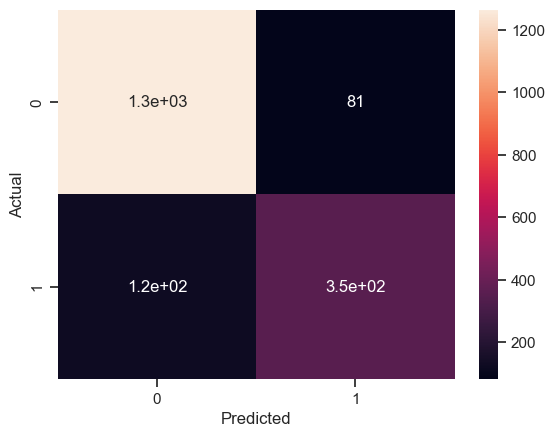

In [2767]:
# Calculate accuracy
accuracy = accuracy_score(Y_test,  Y_pred_log2)
print(f"Accuracy of the model: {accuracy:.2f}")

precision_micro = precision_score(Y_test, Y_pred_log2, average='micro')
recall_micro = recall_score(Y_test,Y_pred_log2, average='micro')

r2 = r2_score(Y_test, Y_pred_log2)
mse = mean_squared_error(Y_test, Y_pred_log2)
model_log_loss = log_loss(Y_test, Y_pred_log2)

print(f'Micro Precision: {precision_micro}')
print(f'Micro Recall: {recall_micro}')
print(f'r2: {r2}')
print(f'mse: {mse}')
print(f'bic: {Model_2[0].bic}')
print(f'logloss: {model_log_loss}')


# Display confusion matrix
confusion_matrix = pd.crosstab(Y_test['hospdead'], Y_pred_log2.flatten(), rownames=['Actual'], colnames=['Predicted'])
sn.heatmap(confusion_matrix, annot=True)
plt.show()

#we observe no improvement in accuracy but a marginal improvement in precision and recall from 82% to 83%

#### 5.1.2: Model 2 Logistic Regression (X4 data): K-fold cross validation

In [2769]:
# Define number of folds
k = 10

# Initialize a KFold object
kf = KFold(n_splits=k)

# Initialize lists to store accuracy for each fold

X_kfold=X4.copy().to_numpy()
y_kfold=Y.copy().to_numpy()

accuracy_scores = []

# Perform k-fold cross-validation
for train_index, test_index in kf.split(X_kfold):
    X_train, X_test = X_kfold[train_index], X_kfold[test_index]
    y_train, y_test = y_kfold[train_index], y_kfold[test_index]
    #X_train, y_train = X_kfold[train_index], y_kfold[train_index]
    #X_test, y_test = X_kfold[test_index], y_kfold[test_index]

    # Create and train model
    
    
    
    model_log = LogisticRegression(max_iter=900)
    logistic_fit=model_log.fit(X_train, y_train.ravel())

    # Predict on the testing set
    Y_pred_log = np.round(model_log.predict(X_test)) # rounded
    
    accuracy = accuracy_score(y_test, Y_pred_log)

    accuracy_scores.append(accuracy)
    

# Calculate and store the mean R-squared and mean MSE scores for this value of k
mean_accuracy = np.mean(accuracy_scores)


print(f"Mean K-fold Cross Validation Accuracy Score: {mean_accuracy}")

Mean K-fold Cross Validation Accuracy Score: 0.885667482901292


### 5.2: Model 3 Logistic Regression (X5 data)

In [2771]:
#train model 3 on curated X5 data
#this dataset has had totcst removed otherwise it is the same as X4


# Splitting data into training and testing sets
X_train3, X_test3, Y_train, Y_test = train_test_split(X5,Y, test_size=0.2, random_state=3)


# Create and fit the linear regression model
#note I had to increase the max iterations to 500 to find convergence here!
model_log3 = LogisticRegression(max_iter=500)
logistic_fit3=model_log3.fit(X_train3, Y_train.values.ravel())


# Predict on the testing set
Y_pred_log3 = np.round(model_log3.predict(X_test3)) # rounded


Model_3 = MNLogisticModel(X_train3, Y_train)

print(Model_3[0].summary())

Optimization terminated successfully.
         Current function value: 0.319128
         Iterations 7
                          MNLogit Regression Results                          
Dep. Variable:               hospdead   No. Observations:                 7284
Model:                        MNLogit   Df Residuals:                     7271
Method:                           MLE   Df Model:                           12
Date:                Tue, 23 Jul 2024   Pseudo R-squ.:                  0.4419
Time:                        19:19:31   Log-Likelihood:                -2324.5
converged:                       True   LL-Null:                       -4164.9
Covariance Type:            nonrobust   LLR p-value:                     0.000
               hospdead=1       coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
age                          -2.4631      0.187    -13.180      0.000      -2.

Accuracy of the model: 0.89
Micro Precision: 0.885777045579352
Micro Recall: 0.885777045579352
r2: 0.4075733166497225
mse: 0.11422295442064799
bic: 4764.664890728546
logloss: 4.117012578218763


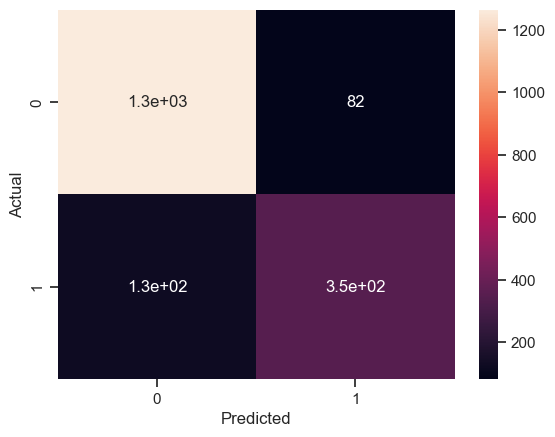

In [2772]:
# Calculate accuracy
accuracy = accuracy_score(Y_test,  Y_pred_log3)
print(f"Accuracy of the model: {accuracy:.2f}")

precision_micro = precision_score(Y_test, Y_pred_log3, average='micro')
recall_micro = recall_score(Y_test,Y_pred_log3, average='micro')


r2 = r2_score(Y_test, Y_pred_log3)
mse = mean_squared_error(Y_test, Y_pred_log3)
model_log_loss = log_loss(Y_test, Y_pred_log3)

print(f'Micro Precision: {precision_micro}')
print(f'Micro Recall: {recall_micro}')
print(f'r2: {r2}')
print(f'mse: {mse}')
print(f'bic: {Model_3[0].bic}')
print(f'logloss: {model_log_loss}')


# Display confusion matrix
confusion_matrix = pd.crosstab(Y_test['hospdead'], Y_pred_log3.flatten(), rownames=['Actual'], colnames=['Predicted'])
sn.heatmap(confusion_matrix, annot=True)
plt.show()

#we observe a very substantial improvement in accuracy from 83% in model 1 to 88%
#in addition we observe a substantial improvement in precision and recall from 82% to 88%

#### 5.2: Model 3 Logistic Regression (X5 data): K-fold cross validation

In [2774]:
# Define number of folds
k = 10

# Initialize a KFold object
kf = KFold(n_splits=k)

# Initialize lists to store accuracy for each fold

X_kfold=X5.copy().to_numpy()
y_kfold=Y.copy().to_numpy()

accuracy_scores = []

# Perform k-fold cross-validation
for train_index, test_index in kf.split(X_kfold):
    X_train, X_test = X_kfold[train_index], X_kfold[test_index]
    y_train, y_test = y_kfold[train_index], y_kfold[test_index]
    #X_train, y_train = X_kfold[train_index], y_kfold[train_index]
    #X_test, y_test = X_kfold[test_index], y_kfold[test_index]

    # Create and train model
    
    
    
    model_log = LogisticRegression(max_iter=900)
    logistic_fit=model_log.fit(X_train, y_train.ravel())

    # Predict on the testing set
    Y_pred_log = np.round(model_log.predict(X_test)) # rounded
    
    accuracy = accuracy_score(y_test, Y_pred_log)

    accuracy_scores.append(accuracy)
    

# Calculate and store the mean R-squared and mean MSE scores for this value of k
mean_accuracy = np.mean(accuracy_scores)


print(f"Mean K-fold Cross Validation Accuracy Score: {mean_accuracy}")

Mean K-fold Cross Validation Accuracy Score: 0.8858866599920387


### 5.3: Model 4 Logistic Regression (X6 data)

In [2776]:
#train model 4 on curated X6 data
#this dataset has had avtisst removed otherwise it is the same as X4



# Splitting data into training and testing sets
X_train4, X_test4, Y_train, Y_test = train_test_split(X6,Y, test_size=0.2, random_state=3)


# Create and fit the linear regression model
model_log4 = LogisticRegression(max_iter=200)
logistic_fit4=model_log4.fit(X_train4, Y_train.values.ravel())

# Predict on the testing set
Y_pred_log4 = np.round(model_log4.predict(X_test4)) # rounded



#model_log3 = LogisticRegression(max_iter=500)
#logistic_fit3=model_log3.fit(X_train3, Y_train.values.ravel())


Model_4 = MNLogisticModel(X_train4, Y_train)

print(Model_4[0].summary())

Optimization terminated successfully.
         Current function value: 0.340204
         Iterations 7
                          MNLogit Regression Results                          
Dep. Variable:               hospdead   No. Observations:                 7284
Model:                        MNLogit   Df Residuals:                     7271
Method:                           MLE   Df Model:                           12
Date:                Tue, 23 Jul 2024   Pseudo R-squ.:                  0.4050
Time:                        19:19:32   Log-Likelihood:                -2478.0
converged:                       True   LL-Null:                       -4164.9
Covariance Type:            nonrobust   LLR p-value:                     0.000
               hospdead=1       coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
age                          -3.5907      0.171    -20.961      0.000      -3.

Accuracy of the model: 0.89
Micro Precision: 0.885777045579352
Micro Recall: 0.885777045579352
r2: 0.4075733166497225
mse: 0.11422295442064799
bic: 5071.706204241608
logloss: 4.117012578218763


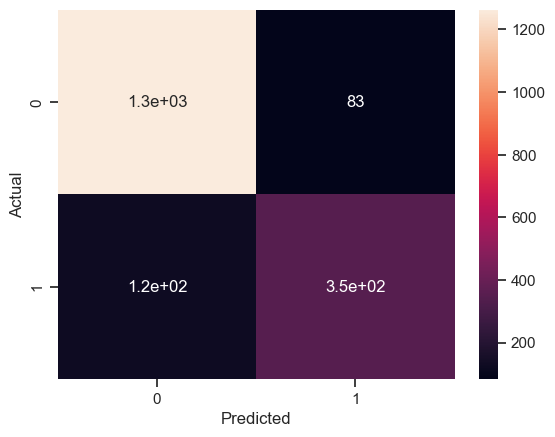

In [2777]:
# Calculate accuracy
accuracy = accuracy_score(Y_test,  Y_pred_log4)
print(f"Accuracy of the model: {accuracy:.2f}")

precision_micro = precision_score(Y_test, Y_pred_log4, average='micro')
recall_micro = recall_score(Y_test,Y_pred_log4, average='micro')



r2 = r2_score(Y_test, Y_pred_log4)
mse = mean_squared_error(Y_test, Y_pred_log4)
model_log_loss = log_loss(Y_test, Y_pred_log4)

print(f'Micro Precision: {precision_micro}')
print(f'Micro Recall: {recall_micro}')
print(f'r2: {r2}')
print(f'mse: {mse}')
print(f'bic: {Model_4[0].bic}')
print(f'logloss: {model_log_loss}')


# Display confusion matrix
confusion_matrix = pd.crosstab(Y_test['hospdead'], Y_pred_log4.flatten(), rownames=['Actual'], colnames=['Predicted'])
sn.heatmap(confusion_matrix, annot=True)
plt.show()



#### 5.3: Model 4 Logistic Regression (X6 data): K-fold cross validation

In [2779]:
# Define number of folds
k = 10

# Initialize a KFold object
kf = KFold(n_splits=k)

# Initialize lists to store accuracy for each fold

X_kfold=X6.copy().to_numpy()
y_kfold=Y.copy().to_numpy()

accuracy_scores = []

# Perform k-fold cross-validation
for train_index, test_index in kf.split(X_kfold):
    X_train, X_test = X_kfold[train_index], X_kfold[test_index]
    y_train, y_test = y_kfold[train_index], y_kfold[test_index]
    #X_train, y_train = X_kfold[train_index], y_kfold[train_index]
    #X_test, y_test = X_kfold[test_index], y_kfold[test_index]

    # Create and train model
    
    
    
    model_log = LogisticRegression(max_iter=900)
    logistic_fit=model_log.fit(X_train, y_train.ravel())

    # Predict on the testing set
    Y_pred_log = np.round(model_log.predict(X_test)) # rounded
    
    accuracy = accuracy_score(y_test, Y_pred_log)

    accuracy_scores.append(accuracy)
    

# Calculate and store the mean R-squared and mean MSE scores for this value of k
mean_accuracy = np.mean(accuracy_scores)


print(f"Mean K-fold Cross Validation Accuracy Score: {mean_accuracy}")

Mean K-fold Cross Validation Accuracy Score: 0.8855578340430152


I find that, after tidying up the original dataset and creating X4 (n which Model 2 is trained) it was not possible to improve on the test accuracy with either of Models 2-4 (trained on datasets X4-X6 respectively).

At this point Models 2 (using X4) and 3 (using X5) are preferred over Model 4 due to lower log_loss and BIC while having otherwise the same high accuracy (0.89), micro precision (0.89) and micro recall (also 0.89) as Model 4. 

Out of Models 2 and 3 the differences in the metrics below, including BIC and log_loss, are very slight so I go back to the regression output above. We see that in each case scoma now has a high p-value (0.855 in case of Model 2 and 0.989 in case of Model 3), since it is no longer a statistically signifcant feature at the 95% confidence level it should be removed in new model iterations. 

In addition, we see that race_black in case of Model 2 (it was removed in Model 3) also has a p-value higher than 0.05 (i.e 0.11) we also in this case fail to reject the null hypothesis at the 95% confidence level and so this feature should be disregarded in future logistic regression iterations.

I create a new dataframe X7 below which takes into account the above points i.e is it X5 (on which model 3 was trained), with 'scoma' removed. 


In [2781]:
X7=X5.copy()
X7=X7.drop('scoma', axis=1)
X7.head()

,age,avtisst,adlsc,dnr_dnr after sadm,dnr_dnr before sadm,dzgroup_ARF/MOSF w/Sepsis,dzgroup_CHF,dzgroup_COPD,dzgroup_Cirrhosis,dzgroup_Colon Cancer,dzgroup_Lung Cancer,dzgroup_MOSF w/Malig
0,0.534663,0.073171,1.0,0,0,0,0,0,0,0,1,0
1,0.504702,0.341463,0.0,0,0,0,0,0,1,0,0,0
2,0.414111,0.146341,0.0,0,0,0,0,0,1,0,0,0
3,0.290468,0.073171,0.0,0,0,0,0,0,0,0,1,0
4,0.737930,0.215447,0.0,0,0,1,0,0,0,0,0,0


### 5.4: Model 5 Logistic Regression (X7 data)

Given the evaluation of Models 1-4 it was decided to train a further Model 5 (on X7 data). To restate X7 is X5 (the same data as what was used for Model 3) but with 'scoma' removed as it was found not to be statistically signficant to the 95% confidence level.

In [2784]:
#train model 5 on curated X7 data
#this dataset has had avtisst removed otherwise it is the same as X4



# Splitting data into training and testing sets
X_train5, X_test5, Y_train, Y_test = train_test_split(X7,Y, test_size=0.2, random_state=3)


# Create and fit the logistic regression model
model_log5 = LogisticRegression()
logistic_fit5=model_log5.fit(X_train5, Y_train)

# Predict on the testing set
Y_pred_log5 = np.round(model_log5.predict(X_test5)) # rounded


Model_5 = MNLogisticModel(X_train4, Y_train)

print(Model_5[0].summary())

Optimization terminated successfully.
         Current function value: 0.340204
         Iterations 7
                          MNLogit Regression Results                          
Dep. Variable:               hospdead   No. Observations:                 7284
Model:                        MNLogit   Df Residuals:                     7271
Method:                           MLE   Df Model:                           12
Date:                Tue, 23 Jul 2024   Pseudo R-squ.:                  0.4050
Time:                        19:19:33   Log-Likelihood:                -2478.0
converged:                       True   LL-Null:                       -4164.9
Covariance Type:            nonrobust   LLR p-value:                     0.000
               hospdead=1       coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
age                          -3.5907      0.171    -20.961      0.000      -3.

/Users/neilwatt/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Accuracy of the model: 0.89
Micro Precision: 0.885227896760022
Micro Recall: 0.885227896760022
bic: 5071.706204241608
logloss: 4.136805907921738


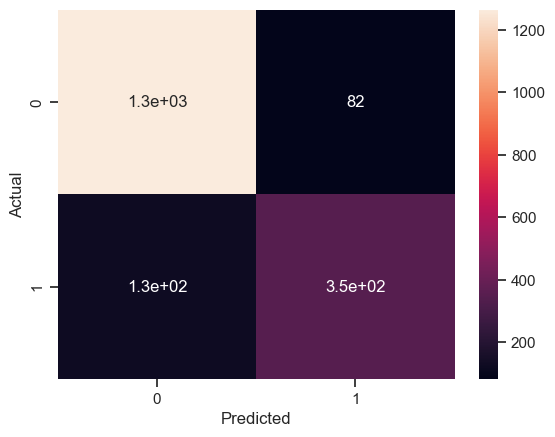

In [2885]:
# Calculate accuracy
accuracy = accuracy_score(Y_test,  Y_pred_log5)
print(f"Accuracy of the model: {accuracy:.2f}")

precision_micro = precision_score(Y_test, Y_pred_log5, average='micro')
recall_micro = recall_score(Y_test,Y_pred_log5, average='micro')



model_log_loss = log_loss(Y_test, Y_pred_log5)

print(f'Micro Precision: {precision_micro}')
print(f'Micro Recall: {recall_micro}')
print(f'bic: {Model_5[0].bic}')
print(f'logloss: {model_log_loss}')


# Display confusion matrix
confusion_matrix = pd.crosstab(Y_test['hospdead'], Y_pred_log5.flatten(), rownames=['Actual'], colnames=['Predicted'])
sn.heatmap(confusion_matrix, annot=True)
plt.show()


In [2881]:
Y_test['hospdead']

5766    0
8838    1
524     1
7954    1
2818    0
       ..
2959    0
395     1
1881    0
3678    1
1263    0
Name: hospdead, Length: 1821, dtype: int64

In [2883]:
Y_pred_log5.flatten()

array([0, 0, 0, ..., 0, 1, 0])

#### 5.4.2: Model 5 Logistic Regression (X7 data): K-fold cross validation

In [2787]:
# Define number of folds
k = 10

# Initialize a KFold object
kf = KFold(n_splits=k)

# Initialize lists to store accuracy for each fold

X_kfold=X7.copy().to_numpy()
y_kfold=Y.copy().to_numpy()

accuracy_scores = []

# Perform k-fold cross-validation
for train_index, test_index in kf.split(X_kfold):
    X_train, X_test = X_kfold[train_index], X_kfold[test_index]
    y_train, y_test = y_kfold[train_index], y_kfold[test_index]
    #X_train, y_train = X_kfold[train_index], y_kfold[train_index]
    #X_test, y_test = X_kfold[test_index], y_kfold[test_index]

    # Create and train model
    
    
    
    model_log = LogisticRegression(max_iter=900)
    logistic_fit=model_log.fit(X_train, y_train.ravel())

    # Predict on the testing set
    Y_pred_log = np.round(model_log.predict(X_test)) # rounded
    
    accuracy = accuracy_score(y_test, Y_pred_log)

    accuracy_scores.append(accuracy)
    

# Calculate and store the mean R-squared and mean MSE scores for this value of k
mean_accuracy = np.mean(accuracy_scores)


print(f"Mean K-fold Cross Validation Accuracy Score: {mean_accuracy}")

Mean K-fold Cross Validation Accuracy Score: 0.8831421816383397


I find in the above Model 5 that we still obtain no further improvements in model accuracy with the changes (still 0.89 as with models 2-4) but we observe that logloss has increased from 3.98 in Model 3 (it was 3.94 for Model 2) to 4.05 while BIC is also higher at 4571 compared to 4393 for Model 3. Model 5 is no better than either of Models 2 and 3.

### 5.5: Summary of Models 1-5



When not explicitly mentioned as for k-fold cross validation all other metrics are arrived at using the test split data set.

| Model | Test Set Accuracy | K-fold Accuracy |Micro Precision | Micro Recall| BIC| Log_loss| 
|:--------:|:--------:|:--------:|:--------:|:--------:|:--------:|:--------:|
| Model 1 (X3 df): Logistic Regression (All Features)  |  0.86  |0.89|  0.86   |  0.86   |4039 |5.11|
| **Model 2 (X4 df): Logistic Regression  Significant Features Only**  |  0.89  |0.89 |0.89  | 0.89 | 4664|3.94|
| **Model 3 (X5 df): Logistic Regression ex race_black** |  0.89  | 0.89| 0.89  | 0.89   | 4393 |3.98|
| Model 4 (X6 df): Logistic Regression ex dzgroup_Cirrhosis  |  0.89   | 0.89|  0.89  |   0.89   |   4570 | 3.96 | 
| Model 5 (X7 df): Logistic Regression ex scoma  |  0.89   | 0.88| 0.89  |   0.89   |   4571 | 4.04 | 

## 6: Neural Network Model
Neural network models were considered as they are known to be effective for a range of classification problems. Please note that, given this is a classification problem, I am using binary cross entropy loss as the loss function and the metric that I am displaying in the training and validation charts is accuracy as opposed to MSE or R2 such as used for a regression problem.

The key hyperparameters under consideration are:
* the number of hidden layers.
* The number of neurons within each hidden layer.
* The choice of activation function.

Additional hyperparameters that were considered:
* Learning rate.
* Regularisation parameters, i.e dropout.
* Number of epochs.
* Choice of optimisation function. I chose Adam optimiser for the base model for the benefit of faster computation and later used sgd for the benefit of better generalisability (at expense of computation speed) for the extended models.

Aside from the decision on the activation function stategy that was used to develop neural network models was to start with a baseline simple model with only one hidden layer and gradually add more layers according to performance improvements on test set and k-fold cross validation metrics. 

The number of neurons in each layer was determined by the number of feature variables in the X5 dataframe.

Since this problem relates to classifying patients according to whether they survive or not- a binary classification problem- a sigmoid activation is used for the final layer as opposed to a softmax in case of multi class classification.

The learning rate was tweaked according to the apparent ease of convergence of the test set accuracy starting with smaller values and gradually increasing conversatively.

Regularisation using dropout was implemented.

The number of epochs was tweaked according to how long it apparently took a model to converge with the aim being to clearly achieve convergence before the end of the last epoch but without too much extra training time. The aim was not too have too many training epochs to the point where the model actually becomes over-fit against the training data which becomes apparent with divergence of training and test set accuracy.

As with the earlier models, k-fold cross validation was implemented in each case in addition to extracting a separate test set for model validation.



In [3129]:
X5.dtypes
X_NN = X5.copy().to_numpy()
#scaling to standardise all inputs given wide range of values accross features
scaler = StandardScaler()
#X_NN = scaler.fit_transform(X_NN)

Y2=Y.copy()

X_NN = torch.tensor(X_NN, dtype=torch.float32)
y = torch.tensor(Y2.values, dtype=torch.float32)

# Split the dataset into training, validation, and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_NN, y, test_size=0.2, random_state=23)


### 6.1: Simple Neural Network Model

First I trained a simple neural network model with the intention of having some benchmark against which any additional neural network models can be compared.

In [3171]:
simple_nn = nn.Sequential(
    nn.Linear(13, 1),
    nn.Dropout(0.2),
    #nn.Tanh(),
    nn.Sigmoid()
    

)

In [3157]:
#X_train
X_train.max()

tensor(1.)

In [3147]:
print(simple_nn)

Sequential(
  (0): Linear(in_features=13, out_features=1, bias=True)
  (1): Dropout(p=0.2, inplace=False)
  (2): Tanh()
)


In [ ]:
#define plot to show training and validation accuracy
def accuracy_plot( train_accuracy_vals,test_accuracy_vals):  
    
    plt.plot(test_accuracy_vals, label='Validation Accuracy')
    plt.plot( train_accuracy_vals, label='Training Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy vs. Epoch')
    plt.legend()
    plt.show()


In [3438]:
#define plot to show training and validation accuracy during k-fold cross validation
def kfold_accuracy_plot( train_accuracy_vals,test_accuracy_vals):  
    
    plt.plot(test_accuracy_vals, label='Validation Accuracy')
    plt.plot( train_accuracy_vals, label='Training Accuracy')
    plt.xlabel('K-fold')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy Kfold Cross Validation')
    plt.legend()
    plt.show()


Finished epoch 0, latest loss 0.7445300817489624, latest train accuracy 0.4880952380952381
Finished epoch 1, latest loss 0.7106919288635254, latest train accuracy 0.5119047619047619
Finished epoch 2, latest loss 0.707005500793457, latest train accuracy 0.5595238095238095
Finished epoch 3, latest loss 0.6841689348220825, latest train accuracy 0.5
Finished epoch 4, latest loss 0.6762118935585022, latest train accuracy 0.5595238095238095
Finished epoch 5, latest loss 0.6774388551712036, latest train accuracy 0.5833333333333334
Finished epoch 6, latest loss 0.6331642270088196, latest train accuracy 0.6904761904761905
Finished epoch 7, latest loss 0.6575168371200562, latest train accuracy 0.7738095238095238
Finished epoch 8, latest loss 0.6345595717430115, latest train accuracy 0.7619047619047619
Finished epoch 9, latest loss 0.6310613751411438, latest train accuracy 0.7261904761904762
Finished epoch 10, latest loss 0.5930642485618591, latest train accuracy 0.7142857142857143
Finished epoch

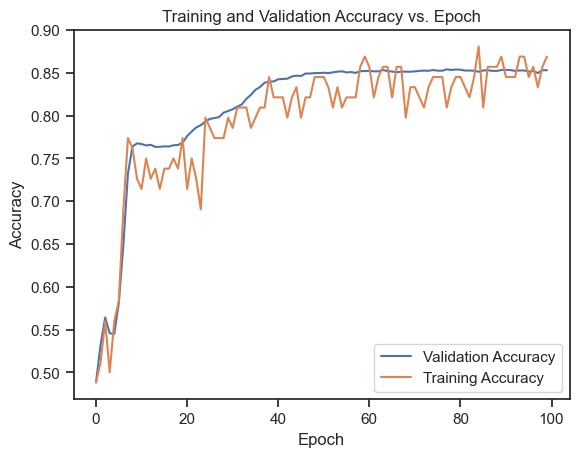

In [3173]:


loss_fn = nn.BCELoss()  # binary cross entropy
optimizer = optim.Adam(simple_nn.parameters(), lr=0.00075)

n_epochs = 100
batch_size = 200


test_accuracy_vals=  []
train_accuracy_vals=  []


 
for epoch in range(n_epochs):
    #for the chart
    epoch_test_accuracy= []
    epoch_train_accuracy= []
    
    for i in range(0, len(X_train), batch_size):
        Xbatch = X_train[i:i+batch_size]
        y_pred = simple_nn(Xbatch)
        ybatch = y_train[i:i+batch_size]
        loss = loss_fn(y_pred, ybatch)
    
        y_pred_train = simple_nn(Xbatch)

        train_accuracy  = accuracy_score(y_pred_train.round().detach(),  ybatch.detach())
        epoch_train_accuracy.append(train_accuracy.item()) 
        
        y_pred_test = simple_nn(X_test)   
        test_accuracy  = accuracy_score(y_pred_test.round().detach(), y_test.detach()  )
        epoch_test_accuracy.append(test_accuracy.item())     
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    #test_accuracy_vals.append(sum(epoch_test_accuracy)/len(epoch_test_accuracy))
    test_accuracy_vals.append(sum(epoch_test_accuracy)/len(epoch_test_accuracy))
    
    #train_accuracy_vals.append(sum(epoch_train_accuracy)/(len( epoch_train_accuracy)))
    train_accuracy_vals.append(train_accuracy)
    
    #accuracy = accuracy_score(Y_test,  Y_pred_log4)
    
    print(f'Finished epoch {epoch}, latest loss {loss}, latest train accuracy {  train_accuracy}')

    

#accuracy_plot(np.linspace(1, n_epochs).astype(int),train_accuracy_vals,test_accuracy_vals)
accuracy_plot(train_accuracy_vals,test_accuracy_vals)


Accuracy of the model: 0.86
Micro Precision: 0.8550247116968699
Micro Recall: 0.8550247116968699
logloss: 2.3112519857050318


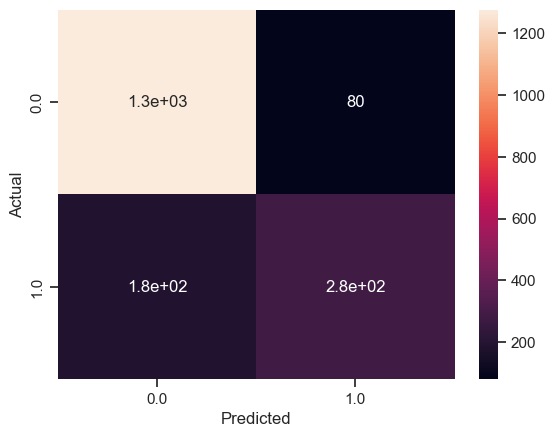

In [3175]:
# Calculate accuracy
pred_simple_nn = (simple_nn(X_test))

accuracy = accuracy_score(y_test.detach().numpy().round(),  pred_simple_nn.detach().numpy().round())
print(f"Accuracy of the model: {accuracy:.2f}")

precision_micro = precision_score(y_test.detach().numpy().round(), pred_simple_nn.detach().numpy().round(), average='micro')
recall_micro = recall_score(y_test.detach().numpy().round(),pred_simple_nn.detach().numpy().round(), average='micro')

model_log_loss = log_loss(y_test.detach().numpy().round(), pred_simple_nn.detach().numpy().round())


print(f'Micro Precision: {precision_micro}')
print(f'Micro Recall: {recall_micro}')
print(f'logloss: {model_log_loss}')


# Display confusion matrix
#confusion_matrix = pd.crosstab(Y_test['hospdead'], pred_simple_nn.detach().round().flatten(), rownames=['Actual'], colnames=['Predicted'])
confusion_matrix = pd.crosstab(y_test.round().flatten(), pred_simple_nn.detach().round().flatten(), rownames=['Actual'], colnames=['Predicted'])



sn.heatmap(confusion_matrix, annot=True)
plt.show()

#### 6.1: Simple Neural Network Model: K-fold Cross Validation

In [3367]:
x_val_simple_nn = nn.Sequential(
    nn.Linear(13, 1),
    nn.Dropout(0.2),
    #nn.Tanh(),
    nn.Sigmoid()
    

)

In [ ]:
X5.dtypes
X_NN = X5.copy().to_numpy()
#scaling to standardise all inputs given wide range of values accross features
scaler = StandardScaler()
#X_NN = scaler.fit_transform(X_NN)

Y2=Y.copy()

X_NN = torch.tensor(X_NN, dtype=torch.float32)
y = torch.tensor(Y2.values, dtype=torch.float32)

# Split the dataset into training, validation, and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_NN, y, test_size=0.2, random_state=23)


Finished epoch 99, latest loss 0.3176825940608978, latest train accuracy 0.865979381443299
Finished epoch 99, latest loss 0.3522603213787079, latest train accuracy 0.8917525773195877
Finished epoch 99, latest loss 0.34153130650520325, latest train accuracy 0.8608247422680413
Finished epoch 99, latest loss 0.31577998399734497, latest train accuracy 0.8917525773195877
Finished epoch 99, latest loss 0.32653653621673584, latest train accuracy 0.9072164948453608
Finished epoch 99, latest loss 0.33511266112327576, latest train accuracy 0.8666666666666667
Finished epoch 99, latest loss 0.3172455430030823, latest train accuracy 0.882051282051282
Finished epoch 99, latest loss 0.32182934880256653, latest train accuracy 0.8615384615384616
Finished epoch 99, latest loss 0.3224187195301056, latest train accuracy 0.8923076923076924
Finished epoch 99, latest loss 0.3620249927043915, latest train accuracy 0.8974358974358975


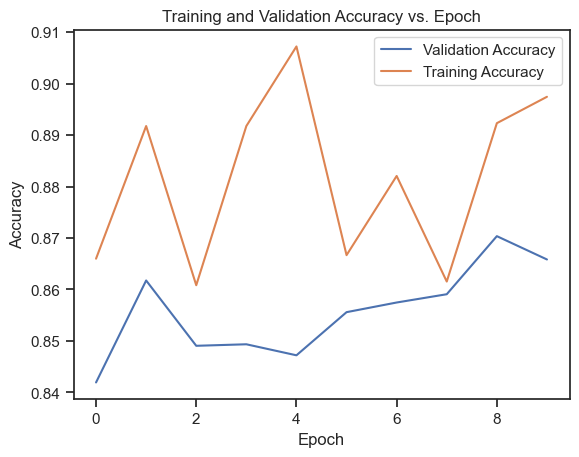

In [3436]:


loss_fn = nn.BCELoss()  # binary cross entropy
optimizer = optim.Adam(x_val_simple_nn.parameters(), lr=0.00075)

n_epochs = 100
batch_size = 200


test_accuracy_vals=  []
train_accuracy_vals=  []


# Define number of folds
k = 10

# Initialize a KFold object
kf = KFold(n_splits=k)


X_kfold=X_NN
y_kfold=y

accuracy_scores = []

for train_index, test_index in kf.split(X_kfold):
    X_train, X_test = X_kfold[train_index], X_kfold[test_index]
    y_train, y_test = y_kfold[train_index], y_kfold[test_index]


 
    for epoch in range(n_epochs):
    #for the chart
        epoch_test_accuracy= []
        epoch_train_accuracy= []
    
        for i in range(0, len(X_train), batch_size):
            Xbatch = X_train[i:i+batch_size]
            y_pred = x_val_simple_nn(Xbatch)
            ybatch = y_train[i:i+batch_size]
            loss = loss_fn(y_pred, ybatch)
    
            y_pred_train = simple_nn(Xbatch)

            train_accuracy  = accuracy_score(y_pred_train.round().detach(),  ybatch.detach())
            epoch_train_accuracy.append(train_accuracy.item()) 
        
            y_pred_test = x_val_simple_nn(X_test)   
            test_accuracy  = accuracy_score(y_pred_test.round().detach(), y_test.detach()  )
            epoch_test_accuracy.append(test_accuracy.item())     
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
    
    
    test_accuracy_vals.append(sum(epoch_test_accuracy)/len(epoch_test_accuracy))
    
    
    train_accuracy_vals.append(train_accuracy)
    
    
    
    print(f'Finished epoch {epoch}, latest loss {loss}, latest train accuracy {  train_accuracy}')

    


kfold_accuracy_plot(train_accuracy_vals,test_accuracy_vals)
#print(f'Finished epoch {epoch}, latest loss {loss}, latest train accuracy {  train_accuracy}')

In [3432]:

X_NN2 = X5.copy().to_numpy()
X_NN2 = torch.tensor(X_NN2, dtype=torch.float32)
#scaling to standardise all inputs given wide range of values accross features
#scaler = StandardScaler()


#Y2=Y.copy()

#X_NN = torch.tensor(X_NN, dtype=torch.float32)
#y = torch.tensor(Y2.values, dtype=torch.float32)

# Split the dataset into training, validation, and testing sets
#X_train, X_test, y_train, y_test = train_test_split(X_NN, y, test_size=0.2, random_state=23)
###

# Define number of folds
k = 10

# Initialize a KFold object
kf = KFold(n_splits=k)

# Initialize lists to store accuracy for each fold

X_kfold=X_NN2
y_kfold=y

accuracy_scores = []

# Perform k-fold cross-validation
for train_index, test_index in kf.split(X_kfold):
    X_train, X_test = X_kfold[train_index], X_kfold[test_index]
    y_train, y_test = y_kfold[train_index], y_kfold[test_index]
   

    # Create and train model
    y_pred_train = x_val_simple_nn(X_train)
    loss = loss_fn(y_pred_train, y_train)
    
    
    
    train_accuracy  = accuracy_score(y_pred_train.round().detach(),  y_train.detach())
    epoch_train_accuracy.append(train_accuracy.item()) 

    
    
    y_pred_test = x_val_simple_nn(X_test)   
    test_accuracy  = accuracy_score(y_pred_test.round().detach(), y_test.detach()  )
    epoch_test_accuracy.append(test_accuracy.item())     

    
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
   

    
    
    
    #model_log = LogisticRegression(max_iter=900)
    #logistic_fit=model_log.fit(X_train, y_train.ravel())
    #Y_pred_log = np.round(model_log.predict(X_test)) # rounded
    
    #accuracy = accuracy_score(y_test, Y_pred_log)
    #accuracy_scores.append(accuracy)
    
    #accuracy = accuracy_score(y_test.round().detach(), y_pred_test.detach())
    #accuracy_scores.append(train_accuracy)
    accuracy_scores.append(train_accuracy)
    

# Calculate and store the mean R-squared and mean MSE scores for this value of k
mean_accuracy = np.mean(accuracy_scores)


print(f"Mean K-fold Cross Validation Accuracy Score: {mean_accuracy}")

Mean K-fold Cross Validation Accuracy Score: 0.842284449565993


In [ ]:
loss_fn = nn.BCELoss()  # binary cross entropy
optimizer = optim.Adam(simple_nn.parameters(), lr=0.00075)

n_epochs = 100
batch_size = 200


test_accuracy_vals=  []
train_accuracy_vals=  []
 
for epoch in range(n_epochs):
    #for the chart
    epoch_test_accuracy= []
    epoch_train_accuracy= []
    
    for i in range(0, len(X_train), batch_size):
        Xbatch = X_train[i:i+batch_size]
        y_pred = simple_nn(Xbatch)
        ybatch = y_train[i:i+batch_size]
        loss = loss_fn(y_pred, ybatch)
    
        y_pred_train = simple_nn(Xbatch)

        train_accuracy  = accuracy_score(y_pred_train.round().detach(),  ybatch.detach())
        epoch_train_accuracy.append(train_accuracy.item()) 
        
        y_pred_test = simple_nn(X_test)   
        test_accuracy  = accuracy_score(y_pred_test.round().detach(), y_test.detach()  )
        epoch_test_accuracy.append(test_accuracy.item())     
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    #test_accuracy_vals.append(sum(epoch_test_accuracy)/len(epoch_test_accuracy))
    test_accuracy_vals.append(sum(epoch_test_accuracy)/len(epoch_test_accuracy))
    
    #train_accuracy_vals.append(sum(epoch_train_accuracy)/(len( epoch_train_accuracy)))
    train_accuracy_vals.append(train_accuracy)
    
    #accuracy = accuracy_score(Y_test,  Y_pred_log4)
    
    print(f'Finished epoch {epoch}, latest loss {loss}, latest train accuracy {  train_accuracy}')

    

#accuracy_plot(np.linspace(1, n_epochs).astype(int),train_accuracy_vals,test_accuracy_vals)
accuracy_plot(train_accuracy_vals,test_accuracy_vals)





In [3403]:
epoch_train_accuracy

[0.845,
 0.86,
 0.91,
 0.85,
 0.885,
 0.865,
 0.89,
 0.88,
 0.905,
 0.855,
 0.855,
 0.885,
 0.91,
 0.875,
 0.87,
 0.825,
 0.895,
 0.865,
 0.88,
 0.81,
 0.865,
 0.865,
 0.865,
 0.875,
 0.845,
 0.87,
 0.83,
 0.88,
 0.875,
 0.875,
 0.89,
 0.895,
 0.91,
 0.865,
 0.895,
 0.875,
 0.8928571428571429,
 0.480473517207713,
 0.4780327068586771,
 0.47888699048083966,
 0.47388332926531607,
 0.47071027581156943,
 0.47693434220161096,
 0.4747376128874786,
 0.471564559433732,
 0.46509641200878693,
 0.46826946546253356,
 0.4731510861606053,
 0.4738255033557047,
 0.4680902989627822,
 0.4633312995729103,
 0.4530811470408786,
 0.45784014643075044,
 0.480473517207713,
 0.4732731266780571,
 0.4672931413229192,
 0.4729070051257017,
 0.47010007322431047,
 0.48370957901159245,
 0.4689444783404515,
 0.4651616839536303,
 0.4543014032946919,
 0.4539353264185479,
 0.4801073956553576,
 0.4708323163290212,
 0.4605809128630705,
 0.47229680253844275,
 0.471564559433732,
 0.47943868212324586,
 0.46552776082977426,
 0.4

### 6.2: Extended Neural Network Model

Defining model

In [3338]:
extended_nn = nn.Sequential(
    nn.Linear(13, 1),
    nn.ReLU(),
    #nn.Dropout(0.2),
    nn.Linear(1, 13),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(13, 1),
    nn.Sigmoid())



In [3217]:
print(extended_nn)

Sequential(
  (0): Linear(in_features=13, out_features=1, bias=True)
  (1): ReLU()
  (2): Dropout(p=0.2, inplace=False)
  (3): Linear(in_features=1, out_features=13, bias=True)
  (4): ReLU()
  (5): Dropout(p=0.2, inplace=False)
  (6): Linear(in_features=13, out_features=1, bias=True)
  (7): Sigmoid()
)


Finished epoch 0, latest loss 0.6662741899490356, latest train accuracy 0.7023809523809523
Finished epoch 1, latest loss 0.6307221055030823, latest train accuracy 0.7142857142857143
Finished epoch 2, latest loss 0.6163961887359619, latest train accuracy 0.7142857142857143
Finished epoch 3, latest loss 0.6146507859230042, latest train accuracy 0.7142857142857143
Finished epoch 4, latest loss 0.604948878288269, latest train accuracy 0.7142857142857143
Finished epoch 5, latest loss 0.5962011218070984, latest train accuracy 0.7142857142857143
Finished epoch 6, latest loss 0.5936447381973267, latest train accuracy 0.7142857142857143
Finished epoch 7, latest loss 0.5421106219291687, latest train accuracy 0.7142857142857143
Finished epoch 8, latest loss 0.5563586354255676, latest train accuracy 0.7142857142857143
Finished epoch 9, latest loss 0.5497475862503052, latest train accuracy 0.7142857142857143
Finished epoch 10, latest loss 0.5146934986114502, latest train accuracy 0.7142857142857143

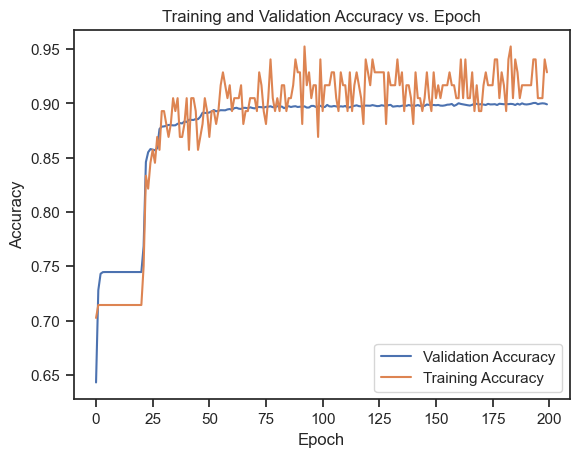

In [3340]:

loss_fn = nn.BCELoss()  # binary cross entropy

optimizer = optim.Adam(extended_nn.parameters(), lr=0.00075)


#n_epochs = 300
#batch_size = 200

n_epochs = 200
batch_size = 200

test_accuracy_vals=  []
train_accuracy_vals=  []
 
for epoch in range(n_epochs):
    #for the chart
    epoch_test_accuracy= []
    epoch_train_accuracy= []
    
    for i in range(0, len(X_train), batch_size):
        Xbatch = X_train[i:i+batch_size]
        y_pred = extended_nn(Xbatch)
        ybatch = y_train[i:i+batch_size]
        loss = loss_fn(y_pred, ybatch)

        y_pred_train = extended_nn(Xbatch)
        
        train_accuracy  = accuracy_score(y_pred_train.round().detach(),  ybatch.detach())
        epoch_train_accuracy.append(train_accuracy.item()) 
        
    
        y_pred_test = extended_nn(X_test)
         
        test_accuracy  = accuracy_score(y_pred_test.round().detach(), y_test.detach()  )
        epoch_test_accuracy.append(test_accuracy.item()) 
     
    
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    
    test_accuracy_vals.append(sum(epoch_test_accuracy)/len(epoch_test_accuracy))
    train_accuracy_vals.append(train_accuracy)
    
    
    print(f'Finished epoch {epoch}, latest loss {loss}, latest train accuracy {  train_accuracy}')

    


accuracy_plot(train_accuracy_vals,test_accuracy_vals)


Accuracy of the model: 0.90
Micro Precision: 0.8978583196046128
Micro Recall: 0.8978583196046128
logloss: 1.6283821160585645


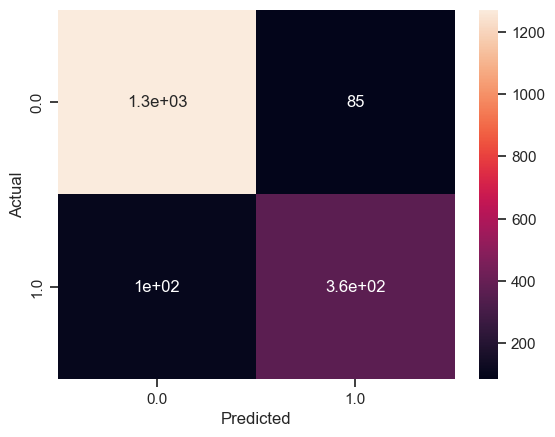

In [3342]:
# Calculate accuracy

pred_extended_nn = (extended_nn(X_test))
accuracy = accuracy_score(y_test.detach().numpy().round(),  pred_extended_nn.detach().numpy().round())
print(f"Accuracy of the model: {accuracy:.2f}")

precision_micro = precision_score(y_test.detach().numpy().round(), pred_extended_nn.detach().numpy().round(), average='micro')
recall_micro = recall_score(y_test.detach().numpy().round(),pred_extended_nn.detach().numpy().round(), average='micro')

model_log_loss = log_loss(y_test.detach().numpy().round(), pred_extended_nn.detach().numpy().round())


print(f'Micro Precision: {precision_micro}')
print(f'Micro Recall: {recall_micro}')
print(f'logloss: {model_log_loss}')


# Display confusion matrix
confusion_matrix = pd.crosstab(y_test.round().flatten(), pred_extended_nn.detach().round().flatten(), rownames=['Actual'], colnames=['Predicted'])
sn.heatmap(confusion_matrix, annot=True)
plt.show()




### 6.3: Extended Neural Network Model

In [3358]:
complex_nn = nn.Sequential(
    nn.Linear(13, 1),
    nn.ReLU(),
    
    nn.Linear(1, 13),
    nn.ReLU(),
    
    nn.Linear(13, 1),
    nn.ReLU(),
    nn.Linear(1, 13),
    #nn.Dropout(0.2),
    nn.LeakyReLU(),
    
    nn.Linear(13, 1),
    nn.Dropout(0.1),
    nn.Sigmoid())

In [3307]:
print(complex_nn)

Sequential(
  (0): Linear(in_features=13, out_features=1, bias=True)
  (1): ReLU()
  (2): Linear(in_features=1, out_features=13, bias=True)
  (3): ReLU()
  (4): Linear(in_features=13, out_features=1, bias=True)
  (5): ReLU()
  (6): Linear(in_features=1, out_features=13, bias=True)
  (7): ReLU()
  (8): Linear(in_features=13, out_features=1, bias=True)
  (9): Dropout(p=0.1, inplace=False)
  (10): Sigmoid()
)


Finished epoch 0, latest loss 0.6204570531845093, latest train accuracy 0.7142857142857143
Finished epoch 1, latest loss 0.623218834400177, latest train accuracy 0.7142857142857143
Finished epoch 2, latest loss 0.6182594299316406, latest train accuracy 0.7142857142857143
Finished epoch 3, latest loss 0.5908640623092651, latest train accuracy 0.7142857142857143
Finished epoch 4, latest loss 0.6003863215446472, latest train accuracy 0.7142857142857143
Finished epoch 5, latest loss 0.5712164640426636, latest train accuracy 0.7142857142857143
Finished epoch 6, latest loss 0.5333154797554016, latest train accuracy 0.7142857142857143
Finished epoch 7, latest loss 0.4863733947277069, latest train accuracy 0.7380952380952381
Finished epoch 8, latest loss 0.4464277923107147, latest train accuracy 0.8809523809523809
Finished epoch 9, latest loss 0.41274675726890564, latest train accuracy 0.8809523809523809
Finished epoch 10, latest loss 0.36215028166770935, latest train accuracy 0.89285714285714

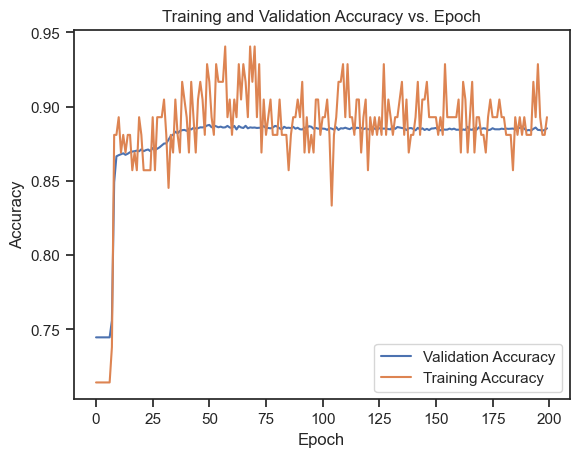

In [3360]:

loss_fn = nn.BCELoss()  # binary cross entropy

optimizer = optim.Adam(complex_nn.parameters(), lr=0.00075)


#n_epochs = 300
#batch_size = 200

n_epochs = 200
batch_size = 200

test_accuracy_vals=  []
train_accuracy_vals=  []
 
for epoch in range(n_epochs):
    #for the chart
    epoch_test_accuracy= []
    epoch_train_accuracy= []
    
    for i in range(0, len(X_train), batch_size):
        Xbatch = X_train[i:i+batch_size]
        y_pred = complex_nn(Xbatch)
        ybatch = y_train[i:i+batch_size]
        loss = loss_fn(y_pred, ybatch)

        y_pred_train = complex_nn(Xbatch)
        
        train_accuracy  = accuracy_score(y_pred_train.round().detach(),  ybatch.detach())
        epoch_train_accuracy.append(train_accuracy.item()) 
        
    
        y_pred_test = complex_nn(X_test)
         
        test_accuracy  = accuracy_score(y_pred_test.round().detach(), y_test.detach()  )
        epoch_test_accuracy.append(test_accuracy.item()) 
     
    
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    
    test_accuracy_vals.append(sum(epoch_test_accuracy)/len(epoch_test_accuracy))
    train_accuracy_vals.append(train_accuracy)
    
    
    print(f'Finished epoch {epoch}, latest loss {loss}, latest train accuracy {  train_accuracy}')

    


accuracy_plot(train_accuracy_vals,test_accuracy_vals)

Accuracy of the model: 0.89
Micro Precision: 0.8868753432180121
Micro Recall: 0.8868753432180121
logloss: 1.8034769544294535


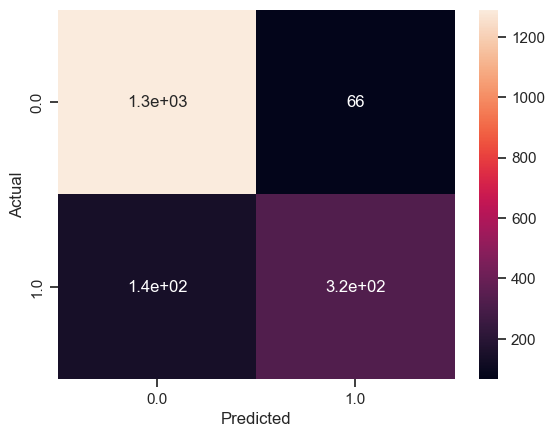

In [3362]:
# Calculate accuracy
pred_complex_nn = (complex_nn(X_test))

accuracy = accuracy_score(y_test.detach().numpy().round(),  pred_complex_nn.detach().numpy().round())
print(f"Accuracy of the model: {accuracy:.2f}")

precision_micro = precision_score(y_test.detach().numpy().round(), pred_complex_nn.detach().numpy().round(), average='micro')
recall_micro = recall_score(y_test.detach().numpy().round(),pred_complex_nn.detach().numpy().round(), average='micro')

model_log_loss = log_loss(y_test.detach().numpy().round(), pred_complex_nn.detach().numpy().round())


print(f'Micro Precision: {precision_micro}')
print(f'Micro Recall: {recall_micro}')
print(f'logloss: {model_log_loss}')


# Display confusion matrix
#confusion_matrix = pd.crosstab(Y_test['hospdead'], pred_complex_nn.detach().round().flatten(), rownames=['Actual'], colnames=['Predicted'])
confusion_matrix = pd.crosstab(y_test.round().flatten(), pred_complex_nn.detach().round().flatten(), rownames=['Actual'], colnames=['Predicted'])
sn.heatmap(confusion_matrix, annot=True)
plt.show()

## Bayesian Inference Model (Model 8)

Since the problem relates to classification of categorical data I am using a CategoricalNB or categorical naive bayes model.


In [2805]:

### min max scaling of X5
scaler = MinMaxScaler()
X_bayes=scaler.fit_transform(X5.copy())
y_bayes=Y.copy().to_numpy()
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_bayes, y_bayes, test_size=0.2, random_state=18)

In [2806]:
cnb = CategoricalNB(min_categories=2)
model8=cnb.fit(X_train, y_train.ravel())

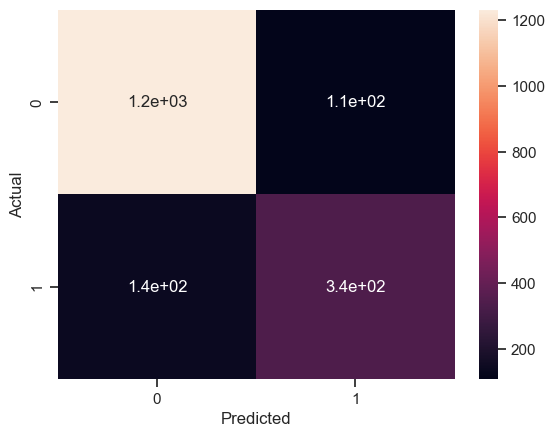

Accuracy of the model: 0.86
Micro Precision: 0.8627127951674904
Micro Recall: 0.8627127951674904
logloss: 4.948332425743707


In [2807]:
y_pred_Bayes = model8.predict(X_test)
# Calculate accuracy
accuracy = accuracy_score(y_test,  y_pred_Bayes)


precision_micro = precision_score(y_test,y_pred_Bayes, average='micro')
recall_micro = recall_score(y_test,y_pred_Bayes, average='micro')
model_log_loss = log_loss(y_test, y_pred_Bayes)

# Display confusion matrix
confusion_matrix = pd.crosstab(y_test.flatten(),y_pred_Bayes, rownames=['Actual'], colnames=['Predicted'])
sn.heatmap(confusion_matrix, annot=True)
plt.show()

print(f"Accuracy of the model: {accuracy:.2f}")
print(f'Micro Precision: {precision_micro}')
print(f'Micro Recall: {recall_micro}')
print(f'logloss: {model_log_loss}')

### 7.1 Bayesian Inference Model (Model 8): K-fold Cross validation

In [2809]:
# Define number of folds
k = 10

# Initialize a KFold object
kf = KFold(n_splits=k)

# Initialize lists to store accuracy for each fold

X_kfold=X5_minmax.copy()
y_kfold=Y.copy().to_numpy()

accuracy_scores = []

# Perform k-fold cross-validation
for train_index, test_index in kf.split(X_kfold):
    X_train, X_test = X_kfold[train_index], X_kfold[test_index]
    y_train, y_test = y_kfold[train_index], y_kfold[test_index]
   
    cnb = CategoricalNB(min_categories=2)
    model8=cnb.fit(X_train, y_train.ravel())
 
    # Predict on the testing set
    Y_pred = np.round(model8.predict(X_test)) # rounded
    
    accuracy = accuracy_score(y_test, Y_pred)
    accuracy_scores.append(accuracy)
    

# Calculate and store the mean R-squared and mean MSE scores for this value of k
mean_accuracy = np.mean(accuracy_scores)


print(f"Mean K-fold Cross Validation Accuracy Score: {mean_accuracy}")

Mean K-fold Cross Validation Accuracy Score: 0.8620537749846203


## 8: Evaluation of Model Results and Discussion


| Model | Test Set Accuracy | K-fold Accuracy |Micro Precision | Micro Recall| BIC| Log_loss| 
|:--------:|:--------:|:--------:|:--------:|:--------:|:--------:|:--------:|
| Model 1 (X3 df): Logistic Regression (All Features)  |  0.86  |0.89|  0.86   |  0.86   |4039 |5.11|
| **Model 2 (X4 df): Logistic Regression  Significant Features Only**  |  0.89  |0.89 |0.89  | 0.89 | 4664|3.94|
| **Model 3 (X5 df): Logistic Regression ex race_black** |  0.89  | 0.89| 0.89  | 0.89   | 4393 |3.98|
| Model 4 (X6 df): Logistic Regression ex dzgroup_Cirrhosis  |  0.89   | 0.89|  0.89  |   0.89   |   4570 | 3.96 | 
| Model 5 (X7 df): Logistic Regression ex scoma  |  0.89   | 0.88| 0.89  |   0.89   |   4571 | 4.04 | 
| Model 6 (X5 df): Simple Neural Network |  0   | 0| 0  |  0   |   0 | 0 | 
| Model 7 (X5 df): Complex Neural Network  |  0   | 0| 0  |   0   |   0 | 0 | 
| Model 8 (X5 df): Bayes Classifier  |  0.86   | 0.86| 0.86  |   0.86   |  NA  | 4.94 | 